In [1]:
import nbimporter
import numpy as np

# import s04_07_Hot_water_floor_heating as hwh
import s07_01_hot_water_demand as dhw
import s08_a_cgs_specification as spec
import s08_d_DHW_of_BB_gas as bb_dhw
import s08_e_water_heating_of_BB_gas as bb_hwh

from s11_01_external_condition import load_outdoor, get_Theta_ex

import matplotlib.pyplot as plt

# 第八章　コージェネレーション設備 / Chapter 8 Cogeneration equipment

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5. ガス消費量 / Gas consumption

$$\large
\displaystyle
E_{G,CG,d,t} = E_{G,PU,d,t} + E_{G,BB,DHW,d,t} + E_{G,BB,HWH,d,t}
$$

$E_{G,CG,d,t}$：日付$d$の時刻$t$における1時間当たりのコージェネレーション設備のガス消費量(MJ/h) / Gas consumption of cogeneration equipment per hour at time $ t $ of date $ d $  
$E_{G,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットのガス消費量(MJ/h) / Gas consumption of the generating unit per hour at time $ t $ of date $ d $  
$E_{G,BB,DHW,d,t}$：日付$d$の時刻$t$における1時間当たりの給湯時のバックアップボイラーのガス消費量(MJ/h) / Gas consumption of backup boiler during hot water supply per hour at time $ t $ on date $ d $  
$E_{G,BB,HWH,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房時のバックアップボイラーのガス消費量(MJ/h) / Gas consumption of backup boiler during hot water heating per hour at time $ t $ of date $ d $  

In [2]:
def calc_E_G_CG_d_t(bath_function, CG, E_E_dmd_d_t,
                    L_dashdash_k_d_t, L_dashdash_w_d_t, L_dashdash_s_d_t, L_dashdash_b1_d_t, L_dashdash_b2_d_t,
                    L_dashdash_ba1_d_t,
                    L_dashdash_ba2_d_t,
                    H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad):
    """1時間当たりのコージェネレーション設備のガス消費量 (1)

    :param bath_function: ふろ機能の種類
    :type bath_function: str
    :param CG: コージェネレーション設備の仕様
    :type CG: dict
    :param E_E_dmd_d_t: 1時間当たりの電力需要 (kWh/h)
    :type E_E_dmd_d_t: ndarray
    :param L_dashdash_k_d_t: 1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_k_d_t: ndarray
    :param L_dashdash_w_d_t: 1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_w_d_t: ndarray
    :param L_dashdash_s_d_t: 1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_s_d_t: ndarray
    :param L_dashdash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b1_d_t: ndarray
    :param L_dashdash_b2_d_t: 1時間当たりの浴槽自動追焚時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b2_d_t: ndarray
    :param L_dashdash_ba1_d_t: 1時間当たりの浴槽水栓さし湯における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba1_d_t: ndarray
    :param L_dashdash_ba2_d_t: 1時間当たりの浴槽追焚の太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba2_d_t: ndarray
    :return: 1時間当たりのコージェネレーション設備の一次エネルギー消費量及び1時間当たりのコージェネレーション設備による発電量
    :rtype: tuple
    """
    # ----- パラメータの取得 -----

    if 'CG_category' in CG:
        # 温水暖房への排熱利用
        exhaust = spec.get_exhaust(CG['CG_category'])

        # 排熱利用方式
        exhaust_priority = spec.get_exhaust_priority(CG['CG_category'])

        # バックアップボイラー(給湯)の熱源種別
        type_BB_DHW = spec.get_type_BB_DHW(CG['CG_category'])

        # バックアップボイラー(給湯)の給湯機の効率
        e_rtd_DHW_BB = spec.get_e_rtd_BB_DHW(CG['CG_category'])

        # バックアップボイラー(温水暖房)の種類
        type_BB_HWH = spec.get_type_BB_HWH(CG['CG_category'])

        # バックアップボイラー(温水暖房)の定格効率
        e_rtd_BB_HWH = spec.get_e_rtd_BB_HWH(CG['CG_category'])

        # バックアップボイラー(温水暖房)の定格能力 (W)
        q_rtd_BB_HWH = spec.get_q_rtd_BB_HWH(CG['CG_category'])

        # 発電ユニットの給湯排熱利用率
        r_DHW_gen_PU_d = spec.get_r_DHW_gen_PU_d(CG['CG_category'])

        # 発電ユニットの温水暖房排熱利用率
        r_HWH_gen_PU_d = spec.get_r_HWH_gen_PU_d(CG['CG_category'])

        # 発電ユニットの発電方式
        PU_type = spec.get_PU_type(CG['CG_category'])

        # 発電ユニットの発電量推定時の仮想発電量のパラメータ a_PU, a_DHW, a_HWH, b, c
        param_E_E_gen_PU_Evt_d = spec.get_param_E_E_gen_PU_EVt_d(CG['CG_category'])

        # 発電ユニットの排熱量推定時の仮想燃料消費量を求める係数
        param_E_F_PU_HVt_d = spec.get_param_E_F_PU_HVt_d(CG['CG_category'])

        # 発電ユニットの排熱量推定時の仮想排熱量の上限比を求める係数 a_DHW, a_HWH, b
        param_r_H_gen_PU_HVt_d = spec.get_param_r_H_gen_PU_HVt_d(CG['CG_category'])

        # 発電ユニットの日平均発電効率を求める係数 a_PU, a_DHW, a_HWH, b, 上限値, 下限値
        param_e_E_PU_d = spec.get_param_e_E_PU_d(CG['CG_category'])

        # 発電ユニットの日平均排熱効率を求める係数 a_PU, a_DHW, a_HWH, b, 上限値, 下限値
        param_e_H_PU_d = spec.get_param_e_H_PU_d(CG['CG_category'])

        # 定格発電出力 (W)
        P_rtd_PU = spec.get_P_rtd_PU(CG['CG_category'])

        # タンクユニットの補機消費電力 (給湯)
        P_TU_aux_DHW = spec.get_P_TU_aux_DHW(CG['CG_category'])

        # タンクユニットの補機消費電力 (温水暖房)
        P_TU_aux_HWH = spec.get_P_TU_aux_HWH(CG['CG_category'])

        # 逆潮流の評価
        has_CG_reverse = CG['reverse'] if 'reverse' in CG else False

    else:
        # 温水暖房への排熱利用
        exhaust = CG['exhaust']

        # 排熱利用方式
        exhaust_priority = CG['exhaust_priority']

        # バックアップボイラー(給湯)の熱源種別
        type_BB_DHW = CG['type_BB_DHW']

        # バックアップボイラー(給湯)の給湯機の効率
        e_rtd_DHW_BB = CG['e_rtd_DHW_BB']

        # バックアップボイラー(温水暖房)の種類
        type_BB_HWH = CG['type_BB_HWH']

        # バックアップボイラー(温水暖房)の定格効率
        e_rtd_BB_HWH = CG['e_rtd_BB_HWH']

        # バックアップボイラー(温水暖房)の定格能力 (W)
        q_rtd_BB_HWH = CG['q_rtd_BB_HWH']

        # 発電ユニットの給湯排熱利用率
        r_DHW_gen_PU_d = CG['r_DHW_gen_PU_d']

        # 発電ユニットの温水暖房排熱利用率
        r_HWH_gen_PU_d = CG['r_HWH_gen_PU_d']

        # 発電ユニットの発電方式
        PU_type = CG['PU_type']

        # 発電ユニットの発電量推定時の仮想発電量のパラメータ a_PU, a_DHW, a_HWH, b, c
        param_E_E_gen_PU_Evt_d = CG['param_E_E_gen_PU_Evt_d']

        # 発電ユニットの排熱量推定時の仮想燃料消費量を求める係数
        param_E_F_PU_HVt_d = CG['param_E_F_PU_HVt_d']

        # 発電ユニットの排熱量推定時の仮想排熱量の上限比を求める係数 a_DHW, a_HWH, b
        param_r_H_gen_PU_HVt_d = CG['param_r_H_gen_PU_HVt_d']

        # 発電ユニットの日平均発電効率を求める係数 a_PU, a_DHW, a_HWH, b, 上限値, 下限値
        param_e_E_PU_d = CG['param_e_E_PU_d']

        # 発電ユニットの日平均排熱効率を求める係数 a_PU, a_DHW, a_HWH, b, 上限値, 下限値
        param_e_H_PU_d = CG['param_e_H_PU_d']

        # 定格発電出力 (W)
        P_rtd_PU = CG['P_rtd_PU']

        # タンクユニットの補機消費電力 (給湯)
        P_TU_aux_DHW = CG['P_TU_aux_DHW']

        # タンクユニットの補機消費電力 (温水暖房)
        P_TU_aux_HWH = CG['P_TU_aux_HWH']

        # 逆潮流の評価
        has_CG_reverse = CG['reverse'] if 'reverse' in CG else False

    # ----- 温水暖房用熱源機の負荷および温水供給運転率の計算 -----

    if H_HS is not None and H_HS['type'] == 'コージェネレーションを使用する':
        # 主たる居室、その他の居室という単位で設定された放熱機器を暖房区画ごとの配列に変換
        rad_list = hwh.get_rad_list(H_MR, H_OR)

        # 温水暖房用熱源機の往き温水温度
        Theta_SW_hs_op = hwh.get_Theta_SW_hs_op(type_BB_HWH)
        p_hs = hwh.calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
        Theta_SW_d_t = hwh.get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

        # 1時間当たりの温水暖房の熱負荷 (MJ/h)
        L_HWH_d_t = hwh.calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                            Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                            mode_MR, mode_OR, L_T_H_rad)

        # 処理暖房負荷
        Q_T_H_rad = np.zeros((5, 24 * 365))
        for i in [1, 3, 4, 5]:

            if rad_list[i - 1] is None:
                continue

            # 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
            A_HCZ = hwh.calc_A_HCZ_i(i, A_A, A_MR, A_OR)
            R_type = '主たる居室' if i == 1 else 'その他の居室'
            mode = mode_MR if i == 1 else mode_OR
            Q_max_H_rad_d_t_i = hwh.calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_d_t, region, mode, R_type)

            # 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
            Q_T_H_rad[i - 1, :] = hwh.calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

        # 温水暖房用熱源機の温水供給運転率
        r_WS_HWH_d_t = hwh.calc_r_WS_hs_d_t(rad_list, L_HWH_d_t, Q_T_H_rad, Theta_SW_d_t, region, A_A, A_MR, A_OR,
                                            mode_MR)
        # 戻り温水温度 (9)
        Theta_RW_hs = hwh.calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                               H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                               mode_MR, mode_OR,
                                               L_T_H_rad)

        # 定格能力の計算のためのパラメータの取得
        rad_types = hwh.get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False
    else:
        L_HWH_d_t = np.zeros(24 * 365)
        P_TU_aux_HWH = np.zeros(24 * 365)
        r_WS_HWH_d_t = np.zeros(24 * 365)

    # 外気温度の取得
    outdoor = load_outdoor()
    Theta_ex_d_t = get_Theta_ex(region, outdoor)
    Theta_ex_Ave = dhw.get_Theta_ex_Ave_d(Theta_ex_d_t)

    # ----- 16. その他 -----

    # 1日当たりの温水暖房の熱負荷 (31)
    L_HWH_d = get_L_HWH_d(L_HWH_d_t)

    # 1時間当たりの発電ユニットによる浴槽追焚を除く給湯熱負荷 (30)
    L_DHW_d_t = get_L_DHW_d_t(L_dashdash_k_d_t, L_dashdash_w_d_t, L_dashdash_s_d_t, L_dashdash_b1_d_t,
                              L_dashdash_b2_d_t, L_dashdash_ba1_d_t)

    # 1日当たりの発電ユニットによる浴槽追焚を除く給湯熱負荷 (MJ/d) (29)
    L_DHW_d = get_L_DHW_d(L_DHW_d_t)

    # ----- 15. タンクユニットの補機消費電力 -----

    # 1時間当たりの浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷 (MJ/h) (28)
    L_BB_DHW_ba2_d_t = get_L_BB_DHW_ba2_d_t(L_dashdash_ba2_d_t)

    # 1時間当たりの浴槽追焚のタンクユニットの補機消費電力量 (kWh/h)
    E_E_TU_aux_ba2_d_t = calc_E_E_TU_aux_ba2_d_t(L_BB_DHW_ba2_d_t)

    # 1時間当たりの温水暖房時のタンクユニットの補機消費電力量 (kWh/h) (27)
    E_E_TU_aux_HWH_d_t = get_E_E_TU_aux_HWH_d_t(exhaust, P_TU_aux_HWH, r_WS_HWH_d_t)

    # 1時間当たりの給湯時のタンクユニットの補機消費電力量 (kWh/h) (26)
    E_E_TU_aux_DHW_d_t = get_E_E_TU_aux_DHW_d_t(P_TU_aux_DHW)

    # 1時間当たりのタンクユニットの補機消費電力量 (25)
    E_E_TU_aux_d_t = get_E_E_TU_aux_d_t(E_E_TU_aux_DHW_d_t, E_E_TU_aux_HWH_d_t, E_E_TU_aux_ba2_d_t)

    '''
    print('E_E_TU_aux_ba2_d_t = {} [kWh/yr] (min={}, max={})'.format(np.sum(E_E_TU_aux_ba2_d_t), min(E_E_TU_aux_ba2_d_t), max(E_E_TU_aux_ba2_d_t)))
    print('E_E_TU_aux_HWH_d_t = {} [kWh/yr] (min={}, max={})'.format(np.sum(E_E_TU_aux_HWH_d_t), min(E_E_TU_aux_HWH_d_t), max(E_E_TU_aux_HWH_d_t)))
    print('E_E_TU_aux_DHW_d_t = {} [kWh]'.format(E_E_TU_aux_DHW_d_t))
    print('E_E_TU_aux_d_t = {} [kWh/yr] (min={}, max={})'.format(np.sum(E_E_TU_aux_d_t), min(E_E_TU_aux_d_t), max(E_E_TU_aux_d_t)))
    '''

    # ----- 14. 発電ユニット -----

    # 発電ユニットの電力需要 (kWh/h) (24)
    E_E_dmd_PU_d_t = get_E_E_dmd_PU_d_t(E_E_dmd_d_t, E_E_TU_aux_d_t)

    # 1時間当たりの発電ユニットの分担可能電力負荷 (kWh/h) (23)
    E_E_PU_d_t = get_E_E_PU_d_t(E_E_dmd_PU_d_t, P_rtd_PU, has_CG_reverse)

    # 1日当たりの発電ユニットの分担可能電力負荷 (kWh/d) (22)
    E_E_PU_d = get_E_E_PU_d(E_E_PU_d_t)

    # 発電ユニットの日平均排熱効率 (-) (21)
    e_H_PU_d = get_e_H_PU_d(E_E_PU_d, L_DHW_d, L_HWH_d, **param_e_H_PU_d)

    # 発電ユニットの日平均発電効率 (-) (20)
    e_E_PU_d = get_e_E_PU_d(E_E_PU_d, L_DHW_d, L_HWH_d, **param_e_E_PU_d)

    if PU_type == '熱主':
        # 発電ユニットの排熱量推定時の仮想排熱量上限比 (-) (19)
        r_H_gen_PU_HVt_d = get_r_H_gen_PU_HVt_d(L_DHW_d, L_HWH_d, **param_r_H_gen_PU_HVt_d)

        # 1日当たりの発電ユニットの排熱量推定時の仮想燃料消費 (MJ/d) (18)
        E_F_PU_HVt_d = get_E_G_PU_HVt_d(e_H_PU_d, L_DHW_d, L_HWH_d, r_H_gen_PU_HVt_d, **param_E_F_PU_HVt_d)
    else:
        E_F_PU_HVt_d = np.zeros(365)

    # 1日当たりの発電ユニットの発電量推定時の仮想発電量 (kWh/d) (17)
    E_E_gen_PU_EVt_d = get_E_E_gen_PU_EVt_d(E_E_PU_d, L_DHW_d, L_HWH_d, **param_E_E_gen_PU_Evt_d)

    # 1日当たりの発電ユニットの発電量推定時の仮想ガス消費量 (MJ/d) (16)
    E_F_PU_EVt_d = get_E_G_PU_EVt_d(E_E_gen_PU_EVt_d, e_E_PU_d)

    # 1日当たりの発電ユニットのガス消費量 (MJ/d) (15)
    E_G_PU_d = get_E_G_PU_d(PU_type, E_F_PU_EVt_d, E_F_PU_HVt_d)

    # 1時間当たりの発電ユニットのガス消費量 (MJ/h) (14a)
    E_G_PU_d_t = calc_E_G_PU_d_t(E_G_PU_d, E_E_PU_d, E_E_PU_d_t, e_E_PU_d)

    # 発電ユニットの発電量 (kWh/h) (10)
    E_E_gen_PU_d_t = get_E_E_gen_PU_d_t(E_G_PU_d_t, e_E_PU_d)

    # 1日当たりの発電ユニット排熱量 (MJ/d) (9)
    Q_PU_gen_d = get_Q_PU_gen_d(E_G_PU_d, e_H_PU_d)

    # 1日当たりの給湯・温水暖房の排熱利用量 (MJ/d) (6)(7)(8)
    Q_gen_DHW_d, Q_gen_HWH_d = get_Q_gen_x_d(exhaust, exhaust_priority, Q_PU_gen_d, r_DHW_gen_PU_d, r_HWH_gen_PU_d,
                                             L_DHW_d, L_HWH_d)

    '''
    print('E_E_dmd_PU_d_t = {} [MJ/yr] (min={}, max={} [MJ/h])'.format(np.sum(E_E_dmd_PU_d_t), min(E_E_dmd_PU_d_t), max(E_E_dmd_PU_d_t)))
    print('P_rtd_PU = {}'.format(P_rtd_PU))
    print('E_E_PU_d = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(E_E_PU_d), min(E_E_PU_d), max(E_E_PU_d)))
    print('E_E_gen_PU_EVt_d = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(E_E_gen_PU_EVt_d), min(E_E_gen_PU_EVt_d), max(E_E_gen_PU_EVt_d)))
    print('e_E_PU_d = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(e_E_PU_d), min(e_E_PU_d), max(e_E_PU_d)))
    print('E_F_PU_EVt_d = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(E_F_PU_EVt_d), min(E_F_PU_EVt_d), max(E_F_PU_EVt_d)))
    print('E_F_PU_HVt_d = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(E_F_PU_HVt_d), min(E_F_PU_HVt_d), max(E_F_PU_HVt_d)))
    print('E_G_PU_d = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(E_G_PU_d), min(E_G_PU_d), max(E_G_PU_d)))
    print('E_G_PU_d_t = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(E_G_PU_d_t), min(E_G_PU_d_t), max(E_G_PU_d_t)))
    print('E_E_gen_PU = {} [MJ/yr] (min={}, max={} [MJ/h])'.format(np.sum(E_E_gen_PU_d_t), min(E_E_gen_PU_d_t), max(E_E_gen_PU_d_t)))
    print('Q_PU_gen = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(Q_PU_gen_d), min(Q_PU_gen_d), max(Q_PU_gen_d)))
    print('Q_gen_DHW = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(Q_gen_DHW_d), min(Q_gen_DHW_d), max(Q_gen_DHW_d)))
    print('Q_gen_HWH = {} [MJ/yr] (min={}, max={} [MJ/d])'.format(np.sum(Q_gen_HWH_d), min(Q_gen_HWH_d), max(Q_gen_HWH_d)))
    '''

    # ----- 13. 温水暖房時のバックアップボイラーのガス消費量(温水暖房への排熱利用がある場合)

    if H_HS is not None and H_HS['type'] == 'コージェネレーションを使用する':
        # 1日当たりの給湯のバックアップボイラーが分担する給湯熱負荷 (MJ/d) (5)
        L_BB_HWH_d_t = get_L_BB_HWH_d_t(L_HWH_d_t, L_HWH_d, Q_gen_HWH_d)

        # 1時間当たりの温水暖房時のバックアップボイラーのガス消費量 (MJ/h)
        E_G_BB_HWH_d_t = bb_hwh.calc_E_G_BB_HWH_d_t(type_BB_HWH, e_rtd_BB_HWH, q_rtd_BB_HWH, L_BB_HWH_d_t, p_hs)
    else:
        L_BB_HWH_d_t = np.zeros(24 * 365)
        E_G_BB_HWH_d_t = np.zeros(24 * 365)

    # ----- 12. 給湯時のバックアップボイラーのガス消費量 ----

    # 1時間あたりのバックアップボイラーが分担する給湯熱負荷 (4)
    L_BB_DHW_d_t, L_BB_DHW_k_d_t, L_BB_DHW_s_d_t, L_BB_DHW_w_d_t, \
    L_BB_DHW_b1_d_t, L_BB_DHW_b2_d_t, L_BB_DHW_ba1_d_t, L_BB_DHW_ba2_d_t = \
        get_L_BB_x_d_t(L_dashdash_k_d_t, L_dashdash_w_d_t, L_dashdash_s_d_t,
                       L_dashdash_b1_d_t, L_dashdash_b2_d_t, L_dashdash_ba1_d_t, L_dashdash_ba2_d_t,
                       Q_gen_DHW_d, L_DHW_d)

    # 1日当たりの給湯時のバックアップボイラーの燃料消費量 (MJ/d) (3)
    E_G_BB_DHW_d_t, E_G_BB_DHW_ba2_d_t = bb_dhw.calc_E_G_BB_DHW_d_t(bath_function,
                                                L_BB_DHW_k_d_t, L_BB_DHW_s_d_t, L_BB_DHW_w_d_t,
                                                L_BB_DHW_b1_d_t, L_BB_DHW_b2_d_t, L_BB_DHW_ba1_d_t, L_BB_DHW_ba2_d_t,
                                                e_rtd_DHW_BB, Theta_ex_Ave)

    # ----- 11. 給湯時のバックアップボイラーの年間平均効率 -----

    # 給湯時のバックアップボイラーの年間平均効率 (-) (6)
    e_BB_ave = get_e_BB_ave(L_BB_DHW_d_t, L_BB_DHW_ba2_d_t, E_G_BB_DHW_d_t, E_G_BB_DHW_ba2_d_t)

    # ----- 10. 製造熱量のうちの自家消費算入分 -----

    # 1年あたりのコージェネレーション設備による製造熱量のうちの自家消費算入分 (MJ/yr) (5)
    Q_CG_h = get_Q_CG_h(L_DHW_d_t)

    # ----- 9. 発電量のうちの自己消費分

    # 1年当たりのコージェネレーション設備による発電量のうちの自己消費分 (kWH/yr) (4)
    E_E_CG_self = get_E_E_CG_self(E_E_TU_aux_d_t)

    # ----- 8. 給湯時のバックアップボイラーの年間平均効率 -----

    # 1年あたりのコージェネレーション設備のガス消費量のうちの売電に係る控除対象分 (MJ/yr) (3)
    E_G_CG_ded = get_E_G_CG_ded(E_G_PU_d_t, E_G_BB_DHW_d_t, E_G_BB_DHW_ba2_d_t)

    # ----- 7. 発電量 -----

    # 1時間当たりのコージェネレーション設備による発電量 (kWh/h) (2)
    E_E_CG_gen_d_t = get_E_E_CG_gen_d_t(E_E_gen_PU_d_t, E_E_TU_aux_d_t)

    # ----- 5. ガス消費量 -----

    # 1時間当たりのコージェネレーション設備のガス消費量 (MJ/h) (1)
    E_G_CG_d_t = E_G_PU_d_t + E_G_BB_DHW_d_t + E_G_BB_HWH_d_t

    '''
    print('E_G_PU = {} [MJ/yr]'.format(np.sum(E_G_PU_d_t)))
    print('E_G_BB_DHW = {} [MJ/yr]'.format(np.sum(E_G_BB_DHW_d_t)))
    print('E_G_BB_HWH = {} [MJ/yr]'.format(np.sum(E_G_BB_HWH_d_t)))
    print('E_E_CG_gen = {} [kWh/yr]'.format(np.sum(E_E_CG_gen_d_t)))
    print('E_G_CG = {} [MJ/yr]'.format(np.sum(E_G_CG_d_t)))
    '''

    return E_G_CG_d_t, E_E_CG_gen_d_t, E_G_CG_ded, E_E_CG_self, Q_CG_h, E_E_TU_aux_d_t, e_BB_ave


### 6. 灯油消費量 / Kerosene consumption

日付$d$の時刻$t$における1時間当たりのコージェネレーション設備の灯油消費量$E_{K,CG,d,t}$は、0とする。 

The kerosene consumption $ E_ {K, CG, d, t} $ of the cogeneration facility per hour at the time $ t $ of the date $ d $ is 0.

In [3]:
def get_E_K_CG_d_t():
    """1時間当たりのコージェネレーション設備の灯油消費量 (MJ/h)

    :return: E_K_CG_d_t 1時間当たりのコージェネレーション設備の灯油消費量 (MJ/h)
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


### 7. 発電量 / Electric-generating capacity

$$\large
\displaystyle
E_{E,CG,gen,d,t} = E_{E,gen,PU,d,t} - E_{E,TU,aux,d,t}
$$

$E_{E,CG,gen,d,t}$：日付$d$の時刻$t$における1時間当たりのコージェネレーション設備による発電量(kWh/h) / Amount of power generated by the cogeneration facility per hour at time $ t $ of date $ d $  
$E_{E,gen,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットの発電量(kWh/h) / Generation amount of generation unit per hour at time $ t $ of date $ d $  
$E_{E,TU,aux,d,t}$：日付$d$の時刻$t$における1時間当たりのタンクユニットの補機消費電力量(kWh/h) / Auxiliary power consumption of tank unit per hour at time $ t $ of date $ d $  

In [4]:
def get_E_E_CG_gen_d_t(E_E_gen_PU_d_t, E_E_TU_aux_d_t):
    """1時間当たりのコージェネレーション設備による発電量 (kWh/h) (2)

    :param E_E_gen_PU_d_t: 1時間当たりの発電ユニットの発電量 (kWh/h)
    :type E_E_gen_PU_d_t: ndarray
    :param E_E_TU_aux_d_t: 1時間当たりのタンクユニットの補機消費電力量 (kWh/h)
    :type E_E_TU_aux_d_t: ndarray
    :return: 1時間当たりのコージェネレーション設備による発電量 (kWh/h)
    :rtype: ndarray
    """
    return E_E_gen_PU_d_t - E_E_TU_aux_d_t


### 8. ガス消費量のうちの売電に係る控除対象分 / Of the gas consumption amount for deduction for selling electricity

$$\large
\displaystyle
E_{G,CG,ded} = \sum^{365}_{d=1} \sum^{23}_{t=0} \bigg(E_{G,PU,d,t}+E_{G,BB,DHW,d,t}-E_{G,BB,DHW,ba2,d,t}\bigg)
$$

$E_{G,CG,ded}$：1 年当たりのコージェネレーション設備のガス消費量のうちの売電に係る控除対象分(MJ/yr) / Of the gas consumption of the cogeneration facility per year, deductible for the sale of electricity   
$E_{G,BB,DHW,ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚時におけるバックアップボイラーのガス消費量(MJ/h) / Gas consumption of backup boiler at the time of bathtub recollection per hour at time $ t $ of date $ d $  
$E_{G,BB,DHW,d,t}$：日付$d$の時刻$t$における1時間当たりの給湯時のバックアップボイラーのガス消費量(MJ/h) / Gas consumption of backup boiler during hot water supply per hour at time $ t $ on date $ d $  
$E_{G,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットのガス消費量(MJ/h) / Gas consumption of the generating unit per hour at time $ t $ of date $ d $  

In [5]:
def get_E_G_CG_ded(E_G_PU_d_t, E_G_BB_DHW_d_t, E_G_BB_DHW_ba2_d_t):
    """1年あたりのコージェネレーション設備のガス消費量のうちの売電に係る控除対象分 (MJ/yr) (3)

    :param E_G_PU_d_t: 日付dの時刻tにおける1時間当たりの発電ユニットのガス消費量 (MJ/h)
    :type E_G_PU_d_t: ndarray
    :param E_G_BB_DHW_d_t: 日付dの時刻tにおける1時間当たりの給湯時のバックアップボイラーのガス消費量 (MJ/h)
    :type E_G_BB_DHW_d_t: ndarray
    :param E_G_BB_DHW_ba2_d_t: 日付dの時刻tにおける1時間当たりの浴槽追焚時におけるバックアップボイラーのガス消費量 (MJ/d)
    :type E_G_BB_DHW_ba2_d_t: ndarray
    :return: 1年あたりのコージェネレーション設備のガス消費量のうちの売電に係る控除対象分 (MJ/yr)
    :rtype: float64
    """
    return np.sum(E_G_PU_d_t + E_G_BB_DHW_d_t - E_G_BB_DHW_ba2_d_t)


### 9. 発電量のうちの自己消費分 / Self-consumption of power generation

$$\large
\displaystyle
E_{G,CG,self} = \sum^{365}_{d=1} \sum^{23}_{t=0} E_{E,TU,aux,d,t}
$$

$E_{G,CG,self}$：1 年当たりのコージェネレーション設備による発電量のうちの自己消費分(kWh/yr) / Of the amount of power generated by cogeneration facilities per year, for consumption  
$ E_{E,TU,aux,d,t}$：日付$d$の時刻$t$における1時間当たりのタンクユニットの補機消費電力量(kWh/h) / Auxiliary power consumption of tank unit per hour at time $ t $ of date $ d $  

In [6]:
def get_E_E_CG_self(E_E_TU_aux_d_t):
    """1年当たりのコージェネレーション設備による発電量のうちの自己消費分 (kWH/yr) (4)

    :param E_E_TU_aux_d_t: 日付dの時刻tにおける1時間当たりのタンクユニットの補機消費電力量 (kWh/yr)
    :type E_E_TU_aux_d_t: ndarray
    :return: 1年当たりのコージェネレーション設備による発電量のうちの自己消費分 (kWH/yr)
    :rtype: float64
    """
    return np.sum(E_E_TU_aux_d_t)


### 10. 製造熱量のうちの自家消費算入分 / Inclusion of self-consumption of heat production

$$\large
\displaystyle
Q_{CG,h} = \sum^{365}_{d=1} \sum^{23}_{t=0} L_{DHW,d,t}
$$

$Q_{CG,h}$：1 年当たりのコージェネレーション設備による製造熱量のうちの自家消費算入分(MJ/yr) / Of consumption heat generated by cogeneration facility per year, including consumption by house  
$L_{DHW,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load excluding bathtub recollections per hour at time $ t $ of date $ d $  

In [7]:
def get_Q_CG_h(L_DHW_d_t):
    """1年あたりのコージェネレーション設備による製造熱量のうちの自家消費算入分 (MJ/yr) (5)

    :param L_DHW_d_t: 日付dの時刻tにおける1時間当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d_t: ndarray
    :return: 1年あたりのコージェネレーション設備による製造熱量のうちの自家消費算入分 (MJ/yr)
    :rtype: float64
    """
    return np.sum(L_DHW_d_t)


### 11. 給湯時のバックアップボイラーの年間平均効率 / Annual average efficiency of backup boiler during hot water supply

$$\large
\displaystyle
e_{BB,ave} = \frac{\sum^{365}_{d=1} \sum^{23}_{t=0} (L_{BB,DHW,d,t}-L_{BB,DHW,ba2,d,t})}{\sum^{365}_{d=1} \sum^{23}_{t=0} (E_{G,BB,DHW,d,t}-E_{G,BB,DHW,ba2,d,t})}
$$

$e_{BB,ave}$：給湯時のバックアップボイラーの年間平均効率(-) / Annual average efficiency of backup boiler during hot water supply  
$L_{BB,DHW,d,t}$：日付$d$の時刻$t$における1時間当たりのバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by the backup boiler per hour at time $ t $ on date $ d $  
$L_{BB,DHW,ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by the backup boiler at the time of bathtub recollection per hour at time $ t $ of date $ d $  
$E_{G,BB,DHW,d,t}$：日付$d$の時刻$t$における1時間当たりの給湯時のバックアップボイラーのガス消費量(MJ/h) / Gas consumption of backup boiler during hot water supply per hour at time $ t $ on date $ d $  
$E_{G,BB,DHW,ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚時におけるバックアップボイラーのガス消費量(MJ/h) / Gas consumption of backup boiler at the time of bathtub recollection per hour at time $ t $ of date $ d $  

In [8]:
def get_e_BB_ave(L_BB_DHW_d_t, L_BB_DHW_ba2_d_t, E_G_BB_DHW_d_t, E_G_BB_DHW_ba2_d_t):
    """給湯時のバックアップボイラーの年間平均効率 (-) (6)

    :param L_BB_DHW_d_t: 1時間当たりのバックアップボイラーが分担する給湯熱負荷 (MJ/h)
    :type L_BB_DHW_d_t: ndarray
    :param L_BB_DHW_ba2_d_t: 1時間当たりの浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷 (MJ/h)
    :type L_BB_DHW_ba2_d_t: ndarray
    :param E_G_BB_DHW_d_t: 1時間当たりの給湯時のバックアップボイラーのガス消費量 (MJ/h)
    :type E_G_BB_DHW_d_t ndarray
    :param E_G_BB_DHW_ba2_d_t: 1時間当たりの浴槽追焚時におけるバックアップボイラーのガス消費量 (MJ/d)
    :type E_G_BB_DHW_ba2_d_t: ndarray
    :return: 給湯時のバックアップボイラーの年間平均効率 (-)
    :rtype: float64
    """
    e_BB_ave = np.sum(L_BB_DHW_d_t - L_BB_DHW_ba2_d_t) / np.sum(E_G_BB_DHW_d_t - E_G_BB_DHW_ba2_d_t)
    return e_BB_ave


### 12. 給湯時のバックアップボイラーのガス消費量 / Gas consumption of backup boiler during hot water supply

#### 12.1 ガス消費量 / Gas consumption

日付$d$の時刻$t$における1時間当たりの給湯時のバックアップボイラーのガス消費量$E_{G,BB,DHW,d,t}$および浴槽追焚時におけるバックアップボイラーのガス消費量$E_{G,BB,DHW,ba2,d,t}$は、ふろ機能の種類、日付$d$の時刻$t$における1時間当たりの台所水栓、浴室シャワー水栓、洗面水栓、浴槽水栓湯はり、浴槽自動湯はり、浴槽水栓さ
し湯、及び浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷$L_{BB,DHW,k,d,t}$、$L_{BB,DHW,s,d,t}$、$L_{BB,DHW,w,d,t}$、$L_{BB,DHW,b1,d,t}$、$L_{BB,DHW,b2,d,t}$、$L_{BB,DHW,ba1,d,t}$及び$L_{BB,DHW,ba2,d,t}$、日付$d$における日平均外気温度$\theta_{ex,ave,d}$に応じて、付録 D により求まる。 

Gas consumption of backup boiler at hot water supply per hour at time $ t $ of date $ d $ $ E_ {G, BB, DHW, d, t}$ and gas consumption of backup boiler at the time of bathtub remembrance $E_ {G, BB, DHW, ba2, d, t}$ is the type of bath function, kitchen faucet per hour at time $ t $ on date $ d $, bathroom shower faucet, flush faucet, bathtub Water faucet, bathtub automatic bath, bathtub faucet
Hot water and hot water supply heat load $ L_ {BB, DHW, k, d, t}$, $ L_ {BB, DHW, s, d, t}$, $ L_ { BB, DHW, w, d, t}$, $ L_ {BB, DHW, b1, d, t}$, $ L_ {BB, DHW, b2, d, t}$, $ L_ {BB, DHW, ba1 , d, t}$ and $ L_ {BB, DHW, ba2, d, t}$, and the daily average outside air temperature $ \theta_ {ex, ave, d}$ at date $ d $ .

#### 12.2 バックアップボイラーが分担する給湯熱負荷 / Hot water supply heat load shared by backup boilers

$$
\displaystyle
L_{BB,DHW,d,t} = L_{BB,DHW,k,d,t}+L_{BB,DHW,s,d,t}+L_{BB,DHW,w,d,t}+L_{BB,DHW,b1,d,t}+L_{BB,DHW,b2,d,t}+L_{BB,DHW,ba1,d,t}+L_{BB,DHW,ba2,d,t}
$$

$$
\displaystyle
L_{BB,DHW,k,d,t} = L''_{k,d,t} - Q_{gen,DHW,d} \times \frac{L''_{k,d,t}}{L_{DHW,d}}
$$

$$
\displaystyle
L_{BB,DHW,s,d,t} = L''_{s,d,t} - Q_{gen,DHW,d} \times \frac{L''_{s,d,t}}{L_{DHW,d}}
$$

$$
\displaystyle
L_{BB,DHW,w,d,t} = L''_{w,d,t} - Q_{gen,DHW,d} \times \frac{L''_{w,d,t}}{L_{DHW,d}}
$$

$$
\displaystyle
L_{BB,DHW,b1,d,t} = L''_{b1,d,t} - Q_{gen,DHW,d} \times \frac{L''_{b1,d,t}}{L_{DHW,d}}
$$

$$
\displaystyle
L_{BB,DHW,b2,d,t} = L''_{b2,d,t} - Q_{gen,DHW,d} \times \frac{L''_{b2,d,t}}{L_{DHW,d}}
$$

$$
\displaystyle
L_{BB,DHW,ba1,d,t} = L''_{ba1,d,t} - Q_{gen,DHW,d} \times \frac{L''_{ba1,d,t}}{L_{DHW,d}}
$$

$$
\displaystyle
L_{BB,DHW,ba2,d,t} = L''_{ba2,d,t}
$$

$L_{BB,DHW,k,d,t}$：日付$d$の時刻$t$における1時間当たりの台所水栓におけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by the backup boiler at the kitchen faucet per hour at time $ t $ of date $ d $  
$L_{BB,DHW,s,d,t}$：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓におけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by the backup boiler in the bathroom shower faucet per hour at time $ t $ of date $ d $  
$L_{BB,DHW,w,d,t}$：日付$d$の時刻$t$における1時間当たりの洗面水栓におけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by the backup boiler in the faucet per hour at time $ t $ of date $ d $  
$L_{BB,DHW,b1,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はりにおけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by backup boiler in bathtub faucet water beam per hour at time $ t $ of date $ d $  
$L_{BB,DHW,b2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はりにおけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by backup boiler in bathtub automatic water beam per hour at time $ t $ of date $ d $  
$L_{BB,DHW,ba1,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯におけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by backup boilers in bathtub faucets and hot water per hour at time $ t $ of date $ d $  
$L_{BB,DHW,ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚におけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by the backup boiler in bathtub recollections per hour at time $ t $ at date $ d $  
$L_{DHW,d}$：日付$d$における1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/d) / Solar heat correction hot water supply heat load excluding one day bathtub remembrance on date $ d $  
$Q_{gen,DHW,d}$：日付$d$における1日当たりの給湯の排熱利用量(MJ/d) / Exhaust heat consumption of hot water supply per day on date $ d $  
$L''_{k,d,t}$：日付$d$の時刻$t$における1時間当たりの台所水栓における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load on kitchen faucet per hour at time $ t $ of date $ d $  
$L''_{w,d,t}$：日付$d$の時刻$t$における1時間当たりの洗面水栓における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in the faucet per hour at time $ t $ of date $ d $  
$L''_{s,d,t}$：日付$d$の時刻$t$における1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in bathroom shower faucet per hour at time $ t $ of date $ d $  
$L''_{b1,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽水栓湯はりにおける太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in bathtub faucet water beam per hour at time $ t $ of date $ d $  
$L''_{b2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽自動湯はりにおける太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in bathtub automatic water beam per hour at time $ t $ of date $ d $  
$L''_{ba1,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽水栓さし湯における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in bathtub faucets per hour per hour at time $ t $ of date $ d $  
$L''_{ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚における太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load in bathtub recollection per hour at time $ t $ of date $ d $  

In [9]:
def get_L_BB_x_d_t(L_dashdash_k_d_t, L_dashdash_w_d_t, L_dashdash_s_d_t,
                   L_dashdash_b1_d_t, L_dashdash_b2_d_t, L_dashdash_ba1_d_t, L_dashdash_ba2_d_t,
                   Q_gen_DHW_d, L_DHW_d):
    """1時間あたりのバックアップボイラーが分担する給湯熱負荷 (7)

    :param L_dashdash_k_d_t: 1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_k_d_t: ndarray
    :param L_dashdash_w_d_t: 1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_w_d_t: ndarray
    :param L_dashdash_s_d_t: 1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_s_d_t: ndarray
    :param L_dashdash_b1_d_t: 1時間当たりの浴槽水栓湯はりにおける太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b1_d_t: ndarray
    :param L_dashdash_b2_d_t: 1時間当たりの浴槽自動湯はりにおける太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b2_d_t: ndarray
    :param L_dashdash_ba1_d_t: 1時間当たりの浴槽水栓さし湯における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba1_d_t: ndarray
    :param L_dashdash_ba2_d_t: 1時間当たりの浴槽水栓さし湯における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba2_d_t: ndarray
    :param Q_gen_DHW_d: 1日当たりの給湯の排熱利用量 (MJ/d)
    :type Q_gen_DHW_d: ndarray
    :param L_DHW_d: 1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d: ndarray
    :return: 1時間あたりのバックアップボイラーが分担する給湯熱負荷(MJ/d)
    :rtype: tuple
    """

    Q_gen_DHW_d = np.repeat(Q_gen_DHW_d, 24)
    L_DHW_d = np.repeat(L_DHW_d, 24)

    # (7b)
    L_BB_DHW_k_d_t = L_dashdash_k_d_t - Q_gen_DHW_d * (L_dashdash_k_d_t / L_DHW_d)

    # (7c)
    L_BB_DHW_s_d_t = L_dashdash_s_d_t - Q_gen_DHW_d * (L_dashdash_s_d_t / L_DHW_d)

    # (7d)
    L_BB_DHW_w_d_t = L_dashdash_w_d_t - Q_gen_DHW_d * (L_dashdash_w_d_t / L_DHW_d)

    # (7e)
    L_BB_DHW_b1_d_t = L_dashdash_b1_d_t - Q_gen_DHW_d * (L_dashdash_b1_d_t / L_DHW_d)

    # (7f)
    L_BB_DHW_b2_d_t = L_dashdash_b2_d_t - Q_gen_DHW_d * (L_dashdash_b2_d_t / L_DHW_d)

    # (7g)
    L_BB_DHW_ba1_d_t = L_dashdash_ba1_d_t - Q_gen_DHW_d * (L_dashdash_ba1_d_t / L_DHW_d)

    # (7h)
    L_BB_DHW_ba2_d_t = L_dashdash_ba2_d_t

    # (7a)
    L_BB_DHW_d_t = L_BB_DHW_k_d_t + \
                   L_BB_DHW_s_d_t + \
                   L_BB_DHW_w_d_t + \
                   L_BB_DHW_b1_d_t + \
                   L_BB_DHW_b2_d_t + \
                   L_BB_DHW_ba1_d_t + \
                   L_BB_DHW_ba2_d_t

    return L_BB_DHW_d_t, L_BB_DHW_k_d_t, L_BB_DHW_s_d_t, L_BB_DHW_w_d_t, \
           L_BB_DHW_b1_d_t, L_BB_DHW_b2_d_t, L_BB_DHW_ba1_d_t, L_BB_DHW_ba2_d_t


### 13. 温水暖房時のバックアップボイラーのガス消費量 / Gas consumption of backup boiler during hot water heating

日付$d$の時刻$t$における1 時間当たりの温水暖房時のバックアップボイラーのガス消費量$E_{G,BB,HWH,d,t}$は、温水暖房のバックアップボイラーの種類、定格効率、定格能力、日付$d$の時刻$t$における 1 時間当たりのバックアップボイラーが分担する温水暖房熱負荷$L_{BB,HWH,d,t}$及び日付$d$の時刻$t$における 1 時間平均の温水暖房用熱源機の往き温水温度$\theta_{SW,HWH,d,t}$に依存し、付録 E によるものとする。

Gas consumption $ E_ {G, BB, HWH, d, t} $ of backup boiler during hot water heating per hour at time $ t $ of date $ d $, type of hot water heating backup boiler, rated efficiency , Rated capacity, hot water heating thermal load $ L_ {BB, HWH, d, t} $ that the backup boiler per hour at time $ t $ on date $ d $ shares and time $ t $ on date $ d $ It depends on Appendix E, depending on the 1 hour average hot water heating heat source machine and the hot water temperature $ \theta_ {SW, HWH, d, t} $.

$$\large
\displaystyle
L_{BB,HWH,d,t} = \left\{ \begin{array}{ll}
    L_{HWH,d,t} - Q_{gen,HWH,d} \times \frac{L_{HWH,d,t}}{L_{HWH,d}} & (L_{HWH,d} > Q_{gen,HWH,d})\\ 
    0 & (L_{HWH,d} \leq Q_{gen,HWH,d})\\ 
    \end{array}
\right.
$$

$L_{HWH,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房の熱負荷(MJ/h) / Hot water heating heat load per hour at time $ t $ on date $ d $  
$L_{HWH,d}$：日付$d$における1日当たりの温水暖房の熱負荷(MJ/d) / Hot water heating heat load per day on date $ d $  
$Q_{gen,HWH,d}$：日付$d$における1日当たりの温水暖房の排熱利用量(MJ/d) / Waste heat utilization of hot water heating per day on date $ d $  

In [10]:
def get_L_BB_HWH_d_t(L_HWH_d_t, L_HWH_d, Q_gen_HWH_d):
    """1時間当たりのバックアップボイラーが分担する温水暖房熱負荷 (MJ/h) (8)

    :param L_HWH_d_t: 1時間当たりの温水暖房の熱負荷 (MJ/h)
    :type L_HWH_d_t: ndarray
    :param L_HWH_d: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH_d: ndarray
    :param Q_gen_HWH_d: 1日当たりの温水暖房の排熱利用量 (MJ/h)
    :type Q_gen_HWH_d: ndarray
    :return: 1時間当たりのバックアップボイラーが分担する温水暖房熱負荷 (MJ/h)
    :rtype: ndarray
    """
    L_BB_HWH_d_t = np.zeros(24 * 365)

    L_HWH_d = np.repeat(L_HWH_d, 24)
    Q_gen_HWH_d = np.repeat(Q_gen_HWH_d, 24)

    # L_HWH_d ≠ 0 の場合
    f1 = (L_HWH_d > Q_gen_HWH_d)
    L_BB_HWH_d_t[f1] = L_HWH_d_t[f1] - Q_gen_HWH_d[f1] * (L_HWH_d_t[f1] / L_HWH_d[f1])

    # L_HWH_d = 0 の場合
    f2 = (L_HWH_d <= Q_gen_HWH_d)
    L_BB_HWH_d_t[f2] = 0

    return L_BB_HWH_d_t


### 14. 発電ユニット / Power generation unit

#### 14.1 排熱利用量 / Waste heat utilization

&#9312;温水暖房への排熱利用がない場合

&#9312; When there is no exhaust heat use for 1 hot water heating

$$\large
\displaystyle
Q_{gen,DHW,d} = \min \left( Q_{PU,gen,d} \times r_{DHW,gen,PU},L_{DHW,d} \right)
$$

$$\large
\displaystyle
Q_{gen,HWH,d} = 0.0
$$

&#9313;温水暖房への排熱利用がある場合で給湯優先の機種

&#9313; When there is exhaust heat utilization to hot water heating, model with hot water supply priority

$$\large
\displaystyle
Q_{gen,DHW,d} = \min \left( Q_{PU,gen,d} \times r_{DHW,gen,PU},L_{DHW,d} \right)
$$

$$\large
\displaystyle
Q_{gen,HWH,d} = \min \left( (Q_{PU,gen,d} - Q_{gen,DHW,d}) \times r_{HWH,gen,PU},L_{HWH,d} \right)
$$

&#9314;温水暖房への排熱利用がある場合で温水暖房優先の機種

&#9314; When there is exhaust heat use to hot water heating, model hot water heating priority

$$\large
\displaystyle
Q_{gen,HWH,d} = \min \left( Q_{PU,gen,d} \times r_{HWH,gen,PU},L_{HWH,d} \right)
$$

$$\large
\displaystyle
Q_{gen,DHW,d} = \min \left( (Q_{PU,gen,d} - Q_{gen,HWH,d}) \times r_{DHW,gen,PU},L_{DHW,d} \right)
$$

$Q_{gen,DHW,d}$：日付$d$における1日当たりの給湯の排熱利用量(MJ/d) / Exhaust heat consumption of hot water supply per day on date $ d $  
$Q_{gen,HWH,d}$：日付$d$における1日当たりの温水暖房の排熱利用量(MJ/d) / Waste heat utilization of hot water heating per day on date $ d $  
$Q_{PU,gen,d}$：日付$d$における1日当たりの発電ユニット排熱量(MJ/d) / Power generation unit exhaust energy per day on date $ d $  
$r_{DHW,gen,PU}$：発電ユニットの給湯排熱利用率 / Hot water exhaust heat utilization rate of power generation unit  
$r_{HWH,gen,PU}$：発電ユニットの温水暖房排熱利用率 / Hot water heating waste heat utilization factor of power generation unit  
$L_{DHW,d}$：日付$d$における1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/d) / Solar heat correction hot water supply heat load excluding one day bathtub remembrance on date $ d $  
$L_{HWH,d}$：日付$d$における1日当たりの温水暖房の熱負荷(MJ/d) / Hot water heating heat load per day on date $ d $  

In [11]:
def get_Q_gen_x_d(exhaust, exhaust_priority, Q_PU_gen_d, r_DHW_gen_PU_d, r_HWH_gen_PU_d, L_DHW_d, L_HWH_d):
    """1日当たりの給湯・温水暖房の排熱利用量 (MJ/d) (9)(10)(11)

    :param exhaust: 温水暖房への排熱利用がある場合はTrue
    :type exhaust: bool
    :param exhaust_priority: 温水暖房への排熱利用がある場合の排熱の優先先
    :type exhaust_priority: str
    :param Q_PU_gen_d:　1日当たりの発電ユニット排熱量 (MJ/d)
    :type Q_PU_gen_d: ndarray
    :param r_HWH_gen_PU_d: 発電ユニットの温水暖房排熱利用率 (-)
    :type r_HWH_gen_PU_d: ndarray
    :param L_DHW_d: 1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d: ndarray
    :param L_HWH_d: 1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_HWH_d: ndarray
    :return: 1日当たりの給湯・温水暖房の排熱利用量をそれぞれ (MJ/d)
    :rtype: tuple
    """
    if exhaust == False:
        # (9b)
        Q_gen_HWH_d = np.zeros(365)
        # (9a)
        Q_gen_DHW_d = np.clip(Q_PU_gen_d * r_DHW_gen_PU_d, None, L_DHW_d)
    elif exhaust_priority == '給湯優先':
        # (10a)
        Q_gen_DHW_d = np.clip(Q_PU_gen_d * r_DHW_gen_PU_d, None, L_DHW_d)
        # (10b)
        Q_gen_HWH_d = np.clip((Q_PU_gen_d - Q_gen_DHW_d) * r_HWH_gen_PU_d, None, L_HWH_d)
    elif exhaust_priority == '温水暖房優先':
        # (11a)
        Q_gen_HWH_d = np.clip(Q_PU_gen_d * r_HWH_gen_PU_d, None, L_HWH_d)
        # (11b)
        Q_gen_DHW_d = np.clip((Q_PU_gen_d - Q_gen_HWH_d) * r_HWH_gen_PU_d, None, L_DHW_d)
    else:
        raise ValueError((exhaust, exhaust_priority))

    return Q_gen_DHW_d, Q_gen_HWH_d


$$\large
\displaystyle
Q_{PU,gen,d} = E_{G,PU,d} \times e_{H,PU,d}
$$

$E_{G,PU,d}$：日付$d$における1日当たりの発電ユニットのガス消費量(MJ/d) / Gas consumption of power generation unit per day on date $ d $  
$e_{H,PU,d}$：日付$d$における発電ユニットの日平均排熱効率 / Daily average heat removal efficiency of generating unit on date $ d $  

In [12]:
def get_Q_PU_gen_d(E_G_PU_d, e_H_PU_d):
    """1日当たりの発電ユニット排熱量 (12)

    :param E_G_PU_d: 1日当たりの発電ユニットのガス消費量 (MJ/d)
    :type E_G_PU_d: ndarray
    :param e_H_PU_d: 発電ユニットの日平均排熱効率 (-)
    :type e_H_PU_d: ndarray
    :return: 1日当たりの発電ユニット排熱量 (MJ/d)
    :rtype: ndarray
    """
    return E_G_PU_d * e_H_PU_d


#### 14.2 発電量 / Electric-generating capacity

$$\large
E_{E,gen,PU,d,t} = E_{G,PU,d,t} \times e_{E,PU,d} \div 3.6
$$

$E_{E,gen,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットの発電量(kWh/h) / Generation amount of generation unit per hour at time $ t $ of date $ d $  
$E_{G,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットのガス消費量(MJ/h) / Gas consumption of the generating unit per hour at time $ t $ of date $ d $  
$e_{E,PU,d}$：日付$d$における発電ユニットの日平均発電効率 / Daily average power generation efficiency of generating unit on date $ d $ 

In [13]:
def get_E_E_gen_PU_d_t(E_G_PU_d_t, e_E_PU_d):
    """1時間当たりの発電ユニットの発電量 (kWh/h) (13)

    :param E_G_PU_d_t: 1時間当たりの発電ユニットのガス消費量 (MJ/h)
    :type E_G_PU_d_t: ndarray
    :param e_E_PU_d: 発電ユニットの日平均発電効率 (-)
    :type e_E_PU_d: ndarray
    :return: 発電ユニットの発電量 (kWh/h)
    :rtype: ndarray
    """
    e_E_PU_d = np.repeat(e_E_PU_d, 24)

    E_E_gen_PU_d_t = E_G_PU_d_t * e_E_PU_d / 3.6

    return E_E_gen_PU_d_t


#### 14.3 ガス消費量 / Gas consumption

$t^*_{PU,start,d}< 23$ の場合

In the case of $t^*_{PU,start,d}< 23$ 

$$\large
\displaystyle
E_{G,PU,d,t} = \left\{ \begin{array}{ll}
    0 & (t < t^*_{PU,start,d})\\ 
    E_{G,PU,d} - E'_{G,PU,d,t+1} & (t = t^*_{PU,start,d})\\ 
    E_{E,PU,d,t} \times 3.6 \div e_{E,PU,d} & (t > t^*_{PU,start,d})\\ 
    \end{array}
\right.
$$

$t^*_{PU,start,d}= 23$ の場合

In the case of $t^*_{PU,start,d}= 23$

$$\large
\displaystyle
E_{G,PU,d,t} = \left\{ \begin{array}{ll}
    0 & (t < t^*_{PU,start,d})\\ 
    E_{G,PU,d} & (t = t^*_{PU,start,d})\\ 
    \end{array}
\right.
$$

$E_{E,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットの分担可能電力負荷(kWh/h) / Shareable power load of generation unit per hour at time $ t $ on date $ d $  
$e_{E,PU,d}$：日付$d$における発電ユニットの日平均発電効率(-) / Daily average power generation efficiency of generating unit on date $ d $  
$E_{G,PU,d}$：日付$d$における1日当たりの発電ユニットのガス消費量(MJ/d) / Gas consumption of power generation unit per day on date $ d $  
$E'_{G,PU,d,t+1}$：日付$d$の時刻$t+1$における当該時刻から 23 時までの発電ユニットのガス消費量(MJ) / Gas consumption of the power generation unit from the relevant time at the time $ t + 1 $ of the date $ d $ to 23:00  
$t^*_{PU,start,d}$：日付$d$における発電ユニットの稼働開始時刻(-) / Generation start time at date $ d $  

In [14]:
def calc_E_G_PU_d_t(E_G_PU_d, E_E_PU_d, E_E_PU_d_t, e_E_PU_d):
    """1時間当たりの発電ユニットのガス消費量 (MJ/h) (14a)

    :param E_G_PU_d: 1日当たりの発電ユニットのガス消費量 (MJ/d)
    :type E_G_PU_d: ndarray
    :param E_E_PU_d: 1日当たりの発電ユニットの分担可能電力力負荷 (kWh/d)
    :type E_E_PU_d: ndarray
    :param E_E_PU_d_t: 1時間当たりの発電ユニットの分担可能電力力負荷 (kWh/h)
    :type E_E_PU_d_t: ndarray
    :param e_E_PU_d: 発電ユニットの日平均発電効率 (-)
    :type e_E_PU_d: ndarray
    :return: 1時間当たりの発電ユニットのガス消費量 (MJ/h)
    :rtype: ndarray
    """

    # 日付dの時刻hにおける当該時刻から23時までの発電ユニットのガス消費量 (MJ/d) (14c)
    E_dash_G_PU_d_h = get_E_dash_G_PU_d_h(E_E_PU_d_t, e_E_PU_d)

    # 日付dにおける発電ユニットの稼働開始時刻 (h) (14b)
    t_star_PU_start_d = get_t_star_PU_start_d(E_G_PU_d, E_dash_G_PU_d_h)

    # 時刻tの表を作成
    t = np.tile(np.arange(24), 365)

    # 計算結果格納領域
    E_G_PU_d_t = np.zeros(24 * 365)

    # 計算用に24時間化
    E_G_PU_d = np.repeat(E_G_PU_d, 24)
    e_E_PU_d = np.repeat(e_E_PU_d, 24)
    t_star_PU_start_d = np.repeat(t_star_PU_start_d, 24)

    # E_dash_G_PU_d_h の1時間後の配列の作成
    E_dash_G_PU_d_h_plus_1h = np.roll(E_dash_G_PU_d_h, -1)

    # 条件1: t_star_PU_start_d < 23 and t < t_star_PU_start_d
    f1 = np.logical_and(t_star_PU_start_d < 23, t < t_star_PU_start_d)
    E_G_PU_d_t[f1] = 0

    # 条件2: t_star_PU_start_d < 23 and t = t_star_PU_start_d
    f2 = np.logical_and(t_star_PU_start_d < 23, t == t_star_PU_start_d)
    E_G_PU_d_t[f2] = E_G_PU_d[f2] - E_dash_G_PU_d_h_plus_1h[f2]

    # 条件3: t_star_PU_start_d < 23 and t > t_star_PU_start_d
    f3 = np.logical_and(t_star_PU_start_d < 23, t > t_star_PU_start_d)
    E_G_PU_d_t[f3] = E_E_PU_d_t[f3] * 3.6 / e_E_PU_d[f3]

    # 条件4: t_star_PU_start_d = 23 and t < t_star_PU_start_d
    f4 = np.logical_and(t_star_PU_start_d == 23, t < t_star_PU_start_d)
    E_G_PU_d_t[f4] = 0

    # 条件5: t_star_PU_start_d = 23 and t = t_star_PU_start_d
    f5 = np.logical_and(t_star_PU_start_d == 23, t == t_star_PU_start_d)
    E_G_PU_d_t[f5] = E_G_PU_d[f5]

    return E_G_PU_d_t


$$\large
\displaystyle
t^*_{PU,start,d} = max \{ h| E_{G,PU,d} \leq E'_{G,PU,d,h} \}
$$

$E'_{G,PU,d,h}$：日付$d$の時刻$h$における当該時刻から 23 時までの発電ユニットのガス消費量(MJ) / Gas consumption of the power generation unit from the relevant time at the time $ h $ on the date $ d $ until 23:00  
$E_{G,PU,d}$：日付$d$における1日当たりの発電ユニットのガス消費量(MJ/d) / Gas consumption of power generation unit per day on date $ d $  

In [15]:
def get_t_star_PU_start_d(E_G_PU_d, E_dash_G_PU_d_h):
    """日付dにおける発電ユニットの稼働開始時刻 (h) (14b)

    :param E_G_PU_d: # 1日当たりの発電ユニットのガス消費量 (MJ/d)
    :type E_G_PU_d: ndarray
    :param E_dash_G_PU_d_h: # 日付dの時刻hにおける当該時刻から23時までの発電ユニットのガス消費量 (MJ/d)
    :type E_dash_G_PU_d_h: ndarray
    :return: 日付dにおける発電ユニットの稼働開始時刻 (h)
    :rtype: ndarray
    """
    # 0,1,2,3...23, 0,1,2...23, .. と 24*365のインデックスを作成
    index_map = np.tile(np.arange(24), 365)

    # E_G_PU_d <= E_dash_PU_d_h を満たすインデックスをTrueにする
    bool_map = np.repeat(E_G_PU_d, 24) <= E_dash_G_PU_d_h

    # index_map のうち、 bool_mapがFalseになっている箇所を0にする
    index_map = index_map * bool_map

    # index_map を 365 * 24 の2次元配列にする
    index_map = np.reshape(index_map, (365, 24))

    # 1日単位で最大のインデックスを取得
    t_star_PU_start_d = np.max(index_map, axis=1)

    return t_star_PU_start_d


$$\large
\displaystyle
E'_{G,PU,d,h} = \sum^{23}_{t=h} E_{E,PU,d,t} \times 3.6 \div e_{E,PU,d}
$$

$E_{E,PU,d,t}$：日付$d$の時刻$h$における 1 時間当たりの発電ユニットの分担可能電力負荷(kWh/h) / Shareable power load of generation unit per hour at time $ h $ on date $ d $  
$e_{E,PU,d}$：日付$d$における発電ユニットの日平均発電効率(-) / Daily average power generation efficiency of generating unit on date $ d $  

In [16]:
def get_E_dash_G_PU_d_h(E_E_PU_d_t, e_E_PU_d):
    """日付dの時刻hにおける当該時刻から23時までの発電ユニットのガス消費量 (MJ/d) (14c)

    :param E_E_PU_d_t: 日付dの時刻tにおける1時間当たりの発電ユニットの分担可能電力負荷 (kWh/h)
    :type E_E_PU_d_t: ndarray
    :param e_E_PU_d: 日付dにおける発電ユニットの日平均発電効率 (-)
    :type e_E_PU_d: ndarray
    :return: 日付dの時刻hにおける当該時刻から23時までの発電ユニットのガス消費量 (MJ/d)
    :rtype: ndarray
    """
    E_E_PU_d_t = np.reshape(E_E_PU_d_t, (365, 24))

    E_dash_G_PU_d_h = np.zeros((365, 24))
    for h in range(24):
        E_dash_G_PU_d_h[:, h] = np.sum(E_E_PU_d_t[:, h:24], axis=1) * 3.6 / e_E_PU_d

    return np.reshape(E_dash_G_PU_d_h, 24*365)


&#9312;発電ユニットの発電方式が「熱主」の場合 

&#9312;When the power generation method of the power generation unit is "heat main"

$$\large
E_{G,PU,d} = min(E_{G,PU,EVt,d}, E_{G,PU,HVt,d})
$$

&#9313;発電ユニットの発電方式が「電主」の場合

&#9313;When the power generation method of the power generation unit is "electricity owner"

$$\large
E_{G,PU,d} = E_{G,PU,EVt,d}
$$

$E_{G,PU,EVt,d}$：日付$d$における1日当たりの発電ユニットの発電量推定時の仮想ガス消費量(MJ/d) / Virtual gas consumption when estimating the amount of power generation of a power generation unit per day on date $ d $  
$E_{G,PU,HVt,d}$：日付$d$における1日当たりの発電ユニットの排熱量推定時の仮想ガス消費量(MJ/d) / Virtual gas consumption at the time of exhaust heat quantity estimation of the power generation unit per day on date $ d $  

In [17]:
def get_E_G_PU_d(PU_type, E_G_PU_EVt_d, E_G_PU_HVt_d=None):
    """1日当たりの発電ユニットのガス消費量 (MJ/d) (15)

    :param PU_type: 発電ユニットの発電方式
    :type PU_type: str
    :param E_G_PU_EVt_d: 1日当たりの発電ユニットの発電量推定時の仮想ガス消費量 (MJ/d)
    :type E_G_PU_EVt_d: ndarray
    :param E_G_PU_HVt_d: 1日当たりの発電ユニットの排熱量推定時の仮想ガス消費量 (MJ/d)
    :type E_G_PU_HVt_d: ndarray
    :return: 1日当たりの発電ユニットの燃料消費量 (MJ/d)
    :rtype: ndarray
    """
    if PU_type == '熱主':
        # (15a)
        return np.clip(E_G_PU_EVt_d, None, E_G_PU_HVt_d)
    elif PU_type == '電主':
        # (15b)
        return E_G_PU_EVt_d
    else:
        raise ValueError(PU_type)


$$\large
E_{G,PU,EVt,d} = E_{E,gen,PU,EVt,d} \times 3.6 \div e_{E,PU,d} 
$$

$E_{E,gen,PU,EVt,d}$：日付$d$における1日当たりの発電ユニットの発電量推定時の仮想発電量(kWh/d) / Virtual power generation amount at the time of power generation amount estimation of the power generation unit per day on date $ d $  
$e_{E,PU,d}$：日付$d$における発電ユニットの日平均発電効率 / Daily average power generation efficiency of generating unit on date $ d $ 

In [18]:
def get_E_G_PU_EVt_d(E_E_gen_PU_EVt_d, e_E_PU_d):
    """1日当たりの発電ユニットの発電量推定時の仮想ガス消費量 (MJ/d) (16)

    :param E_E_gen_PU_EVt_d: 1日当たりの発電ユニットの発電量推定時の仮想発電量 (kWh/d)
    :type E_E_gen_PU_EVt_d: ndarray
    :param e_E_PU_d: 発電ユニットの日平均発電効率 (-)
    :type e_E_PU_d: ndarray
    :return: 1日当たりの発電ユニットの発電量推定時の仮想燃料消費量 (MJ/d)
    :rtype: ndarray
    """
    return E_E_gen_PU_EVt_d * 3.6 / e_E_PU_d


$$\large
\displaystyle
E_{E,gen,PU,EVt,d} = \min ( a_{PU} \times E_{E,PU,d} \times 3.6 + a_{DHW} \times L_{DHW,d} + a_{HWH} \times L_{HWH,d} \\
\large+ b, E_{E,PU,d} \times c \times 3.6) \div 3.6
$$

$E_{E,PU,d}$：日付$d$における1日当たりの発電ユニットの分担可能電力負荷(kWh/d) / Shareable power load of generation unit per day on date $ d $  
$L_{DHW,d}$：日付$d$における1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/d) / Solar heat correction hot water supply heat load excluding one day bathtub remembrance on date $ d $  
$L_{HWH,d}$：日付$d$における1日当たりの温水暖房の熱負荷(MJ/d) / Hot water heating heat load per day on date $ d $  

In [19]:
def get_E_E_gen_PU_EVt_d(E_E_PU_d, L_DHW_d, L_HWH_d, a_PU, a_DHW, a_HWH, b, c):
    """1日当たりの発電ユニットの発電量推定時の仮想発電量 (kWh/d) (17)

    :param E_E_PU_d: 1日当たりの発電ユニットの分担可能電力負荷 (kWh/d)
    :type E_E_PU_d: ndarray
    :param L_DHW_d: 1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d: ndarray
    :param L_HWH_d: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH_d: ndarray
    :param a_PU: パラメータ a_PU
    :type a_PU: float
    :param a_DHW: パラメータ a_DHW
    :type a_DHW: float
    :param a_HWH: パラメータ a_HWH
    :type a_HWH: float
    :param b: パラメータ b
    :type b: float
    :param c: パラメータ c
    :type c: float
    :return: 1日当たりの発電ユニットの発電量推定時の仮想発電量
    :rtype: ndarray
    """
    E_E_gen_PU_EVt_d = np.clip(a_PU * E_E_PU_d * 3.6 + a_DHW * L_DHW_d + a_HWH * L_HWH_d + b, None,
                               E_E_PU_d * c * 3.6) / 3.6
    return E_E_gen_PU_EVt_d


$$\large
\displaystyle
E_{G,PU,HVt,d} = (a_{DHW} \times L_{DHW,d} + a_{HWH} \times L_{HWH,d}) \times r_{H,gen,PU,HVt,d} \div e_{H,PU,d}
$$

$L_{DHW,d}$：日付$d$における1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/d) / Solar heat correction hot water supply heat load excluding one day bathtub remembrance on date $ d $  
$L_{HWH,d}$：日付$d$における1日当たりの温水暖房の熱負荷(MJ/d) / Hot water heating heat load per day on date $ d $  
$r_{H,gen,PU,HVt,d}$：日付$d$における発電ユニットの排熱量推定時の仮想排熱量上限比 / Virtual exhaust heat quantity upper limit ratio at the time of exhaust heat quantity estimation of the power generation unit at date $ d $  
$e_{H,PU,d}$：日付$d$における発電ユニットの日平均排熱効率 / Daily average heat removal efficiency of generating unit on date $ d $  

In [20]:
def get_E_G_PU_HVt_d(e_H_PU_d, L_DHW_d, L_HWH_d, r_H_gen_PU_HVt_d, a_DHW, a_HWH):
    """1日当たりの発電ユニットの排熱量推定時の仮想燃料消費 (MJ/d) (18)

    :param e_H_PU_d: 発電ユニットの日平均排熱効率 (-)
    :type e_H_PU_d: ndarray
    :param L_DHW_d: 1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d: ndarray
    :param L_HWH_d: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH_d: ndarray
    :param r_H_gen_PU_HVt_d: 発電ユニットの排熱量推定時の仮想排熱量上限比 (-)
    :type r_H_gen_PU_HVt_d: ndarray
    :param a_DHW: パラメータ a_DHW
    :type a_DHW: float
    :param a_HWH: パラメータ a_HWH
    :type a_HWH: float
    :return: 1日当たりの発電ユニットの排熱量推定時の仮想燃料消費 (MJ/d)
    :rtype: ndarray
    """
    E_G_PU_HVt_d = (a_DHW * L_DHW_d + a_HWH * L_HWH_d) * r_H_gen_PU_HVt_d / e_H_PU_d
    return E_G_PU_HVt_d


$$\large
\displaystyle
r_{H,gen,PU,HVt,d} = a_{DHW} \times L_{DHW,d} + a_{HWH} \times L_{HWH,d} + b
$$

$L_{DHW,d}$：日付$d$における1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/d) / Solar heat correction hot water supply heat load excluding one day bathtub remembrance on date $ d $  
$L_{HWH,d}$：日付$d$における1日当たりの温水暖房の熱負荷(MJ/d) / Hot water heating heat load per day on date $ d $  

In [21]:
def get_r_H_gen_PU_HVt_d(L_DHW_d, L_HWH_d, a_DHW, a_HWH, b):
    """発電ユニットの排熱量推定時の仮想排熱量上限比 (-) (19)

    :param L_DHW_d: 1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d: ndarray
    :param L_HWH_d: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH_d: ndarray
    :param a_DHW: パラメータ a_DHW
    :type a_DHW: float
    :param a_HWH: パラメータ a_HWH
    :type a_HWH: float
    :param b: パラメータ b
    :type b: float
    :return: 発電ユニットの排熱量推定時の仮想排熱量上限比
    :rtype: ndarray
    """
    r_H_gen_PU_HVt_d = a_DHW * L_DHW_d + a_HWH * L_HWH_d + b
    return r_H_gen_PU_HVt_d


#### 14.4 発電効率 / Power generation efficiency

発電ユニットの発電効率の上限値を上回る場合は上限値に等しいとし、下限値を下回る場合は下限値に等しいとする。

If it exceeds the upper limit of the power generation efficiency of the power generation unit, it is assumed to be equal to the upper limit, and if it is below the lower limit, it is assumed to be equal to the lower limit.

$$\large
\displaystyle
e_{E,PU,d} = a_{PU} \times E_{E,PU,d} \times 3.6 + a_{DHW} \times L_{DHW,d} + a_{HWH} \times L_{HWH,d} + b
$$

$E_{E,PU,d}$：日付$d$における1日当たりの発電ユニットの分担可能電力負荷(kWh/d) / Shareable power load of generation unit per day on date $ d $  
$L_{DHW,d}$：日付$d$における1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/d) / Solar heat correction hot water supply heat load excluding one day bathtub remembrance on date $ d $  
$L_{HWH,d}$：日付$d$における1日当たりの温水暖房の熱負荷(MJ/d) / Hot water heating heat load per day on date $ d $  

In [22]:
def get_e_E_PU_d(E_E_PU_d, L_DHW_d, L_HWH_d, a_PU, a_DHW, a_HWH, b, e_E_PU_d_max, e_E_PU_d_min):
    """発電ユニットの日平均発電効率 (-) (20)

    :param E_E_PU_d: 1日当たりの発電ユニットの分担可能電力負荷 (kWh/d)
    :type E_E_PU_d: ndarray
    :param L_DHW_d: 1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d: ndarray
    :param L_HWH_d: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH_d: ndarray
    :param a_PU: パレメータ a_PU
    :type a_PU: float
    :param a_DHW: パラメータ a_DHW
    :type a_DHW: float
    :param a_HWH: パラメータ a_HWH
    :type a_HWH: float
    :param b: パラメータ b
    :type b: float
    :param e_E_PU_d_max: 上限値
    :type e_E_PU_d_max: float
    :param e_E_PU_d_min: 下限値
    :type e_E_PU_d_min: float
    :return: 発電ユニットの日平均発電効率 (-)
    :rtype: ndarray
    """

    e_E_PU_d = a_PU * E_E_PU_d * 3.6 + a_DHW * L_DHW_d + a_HWH * L_HWH_d + b

    return np.clip(e_E_PU_d, e_E_PU_d_min, e_E_PU_d_max)


#### 14.5 排熱効率 / Exhaust heat efficiency

発電ユニットの排熱効率の上限値を上回る場合は上限値に等しいとし、下限値を下回る場合は下限値に等しいとする。

If it exceeds the upper limit of the heat removal efficiency of the power generation unit, it is assumed that it is equal to the upper limit, and if it is less than the lower limit, it is assumed that it is equal to the lower limit.

$$\large
\displaystyle
e_{H,PU,d} = a_{PU} \times E_{E,PU,d} \times 3.6 + a_{DHW} \times L_{DHW,d} + a_{HWH} \times L_{HWH,d} + b
$$

$E_{E,PU,d}$：日付$d$における1日当たりの発電ユニットの分担可能電力負荷(kWh/d) / Shareable power load of generation unit per day on date $ d $  
$L_{DHW,d}$：日付$d$における1日当たりの浴槽追焚を除く太陽熱補正給湯熱負荷(MJ/d) / Solar heat correction hot water supply heat load excluding one day bathtub remembrance on date $ d $  
$L_{HWH,d}$：日付$d$における1日当たりの温水暖房の熱負荷(MJ/d) / Hot water heating heat load per day on date $ d $  

In [23]:
def get_e_H_PU_d(E_E_PU_d, L_DHW_d, L_HWH_d, a_PU, a_DHW, a_HWH, b, e_H_PU_d_min, e_H_PU_d_max):
    """発電ユニットの日平均排熱効率 (-) (21)

    :param E_E_PU_d: 1日当たりの発電ユニットの分担可能電力負荷 (kWh/d)
    :type E_E_PU_d: ndarray
    :param L_DHW_d: 1日当たりの浴槽追焚をの除く太陽熱補正給湯熱負荷 (MJ/d)
    :type L_DHW_d: ndarray
    :param L_HWH_d: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :type L_HWH_d: ndarray
    :param a_PU: パレメータ a_PU
    :type a_PU: float
    :param a_DHW: パラメータ a_DHW
    :type a_DHW: float
    :param a_HWH: パラメータ a_HWH
    :type a_HWH: float
    :param b: パラメータ b
    :type b: float
    :param e_H_PU_d_max: 上限値
    :type e_H_PU_d_max: float
    :param e_H_PU_d_min: 下限値
    :type e_H_PU_d_min: float
    :return: 発電ユニットの日平均排熱効率 (-)
    :rtype: ndarray
    """
    e_H_PU_d = a_PU * E_E_PU_d * 3.6 + a_DHW * L_DHW_d + a_HWH * L_HWH_d + b

    return np.clip(e_H_PU_d, e_H_PU_d_min, e_H_PU_d_max)

#### 14.6 分担可能電力負荷 / Shareable power load

$$\large
\displaystyle
E_{E,PU,d} = \sum E_{E,PU,d,t}
$$

$E_{E,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットの分担可能電力負荷(kWh/h) / Shareable power load of generation unit per hour at time $ t $ on date $ d $ 

In [24]:
def get_E_E_PU_d(E_E_PU_d_t):
    """1日当たりの発電ユニットの分担可能電力負荷 (kWh/d) (22)

    :param E_E_PU_d_t: 1時間当たりの発電ユニットの分担可能電力負荷 (kWh/h)
    :type E_E_PU_d_t: ndarray
    :return: 1日当たりの発電ユニットの分担可能電力負荷 (kWh/d)
    :rtype: ndarray
    """
    tmp = E_E_PU_d_t.reshape((365, 24))
    E_E_PU_d = np.sum(tmp, axis=1)

    return E_E_PU_d


$$\large
\displaystyle
E_{E,PU,d,t} = \left\{ \begin{array}{ll}
    \min \left( E_{E,dmd,PU,d,t}, P_{rtd,PU} \times 10^{-3} \right) & (逆潮流がない場合)\\ 
    P_{rtd,PU} \times 10^{-3} & (逆潮流がある場合)\\ 
    \end{array}
\right.
$$

$E_{E,dmd,PU,d,t}$：日付$d$の時刻$t$における1時間当たりの発電ユニットの電力需要(kWh/h) / Electricity demand of generating unit per hour at time $ t $ of date $ d $  
$P_{rtd,PU}$：定格発電出力(W) / Rated power output  

In [25]:
def get_E_E_PU_d_t(E_E_dmd_PU_d_t, P_rtd_PU, reverse):
    """1時間当たりの発電ユニットの分担可能電力負荷 (kWh/h) (23)

    :param E_E_dmd_PU_d_t: 1時間当たりの発電ユニットの電力需要 (kWh/h)
    :type E_E_dmd_PU_d_t: ndarray
    :param P_rtd_PU: 定格発電出力 (W)
    :type P_rtd_PU: int
    :param reverse: 逆潮流の有無
    :type reverse: bool
    :return: 1時間当たりの発電ユニットの分担可能電力負荷  (kWh/h)
    :rtype: ndarray
    """
    if reverse == False:
        return np.clip(E_E_dmd_PU_d_t, None, P_rtd_PU * 10 ** (-3))
    else:
        return np.ones_like(E_E_dmd_PU_d_t) * P_rtd_PU * 10 ** (-3)


$$\large
\displaystyle
E_{E,dmd,PU,d,t} = E_{E,dmd,d,t} + E_{E,TU,aux,d,t}
$$

$E_{E,dmd,d,t}$：日付$d$の時刻$t$における1時間当たりの電力需要(kWh/h) / Power demand per hour at time $ t $ of date $ d $  
$E_{E,TU,aux,d,t}$：日付$d$の時刻$t$における1時間当たりのタンクユニットの補機消費電力量(kWh/h) / Auxiliary power consumption of tank unit per hour at time $ t $ of date $ d $  

In [26]:
def get_E_E_dmd_PU_d_t(E_E_dmd_d_t, E_E_TU_aux_d_t):
    """発電ユニットの電力需要 (kWh/h) (24)

    :param E_E_dmd_d_t: 1時間当たりの電力需要 (kWh/h)
    :type E_E_dmd_d_t: ndarray
    :param E_E_TU_aux_d_t: 1時間当たりのタンクユニットの補機消費電力量 (kWh/h)
    :type E_E_TU_aux_d_t: ndarray
    :return: 発電ユニットの電力需要 (kWh/h)
    :type ndarray
    """
    E_E_dmd_PU_d_t = E_E_dmd_d_t + E_E_TU_aux_d_t

    return E_E_dmd_PU_d_t


### 15. タンクユニットの補機消費電力 / Auxiliary power consumption of tank unit

$$\large
\displaystyle
E_{E,TU,aux,d,t} = E_{E,TU,aux,DHW,d,t} + E_{E,TU,aux,HWH,d,t} + E_{E,TU,aux,ba2,d,t}
$$

$E_{E,TU,aux,DHW,d,t}$：日付$d$の時刻$t$における1時間当たりの給湯時のタンクユニットの補機消費電力量(kWh/h) / Auxiliary power consumption of tank unit during hot water supply per hour at time $ t $ of date $ d $  
$E_{E,TU,aux,HWH,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房時のタンクユニットの補機消費電力量(kWh/h) / Auxiliary unit power consumption of tank unit at the time of hot water heating per hour at time $ t $ of date $ d $  
$E_{E,TU,aux,ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚のタンクユニットの補機消費電力量(kWh/h) / Auxiliary unit power consumption of the tank unit tank unit per hour at time $ t $ on date $ d $  

In [27]:
def get_E_E_TU_aux_d_t(E_E_TU_aux_DHW_d_t, E_E_TU_aux_HWH_d_t, E_E_TU_aux_ba2_d_t):
    """1時間当たりのタンクユニットの補機消費電力量 (25)

    :param E_E_TU_aux_DHW_d_t: 1時間当たりの給湯時のタンクユニットの補機消費電力量 (kWh/h)
    :type E_E_TU_aux_DHW_d_t: ndarray
    :param E_E_TU_aux_HWH_d_t: 1時間当たりの温水暖房時のタンクユニットの補機消費電力量 (kWh/h)
    :type E_E_TU_aux_HWH_d_t: ndarray
    :param E_E_TU_aux_ba2_d_t: 1時間当たりの浴槽追焚のタンクユニットの補機消費電力量 (kWh/h)
    :type E_E_TU_aux_ba2_d_t: ndarray
    :return: 1時間当たりのタンクユニットの補機消費電力量 (kWh/h)
    :rtype: ndarray
    """
    E_E_TU_aux_d_t = E_E_TU_aux_DHW_d_t + E_E_TU_aux_HWH_d_t + E_E_TU_aux_ba2_d_t
    return E_E_TU_aux_d_t


$$\large
\displaystyle
E_{E,TU,aux,DHW,d,t} = P_{TU,aux,DHW} \times 10^{-3}
$$

$P_{TU,aux,DHW}$：給湯のタンクユニットの補機消費電力(W) / Auxiliary power consumption of hot water tank unit  

In [28]:
def get_E_E_TU_aux_DHW_d_t(P_TU_aux_DHW):
    """1時間当たりの給湯時のタンクユニットの補機消費電力量 (kWh/h) (26)

    :param P_TU_aux_DHW: 給湯のタンクユニットの補機消費電力 (W)
    :type P_TU_aux_DHW: float
    :return: 1時間当たりの給湯時のタンクユニットの補機消費電力量 (kWh/h)
    :rtype: float
    """
    E_E_TU_aux_DHW_d_t = P_TU_aux_DHW * 10 ** (-3)
    return E_E_TU_aux_DHW_d_t


$$\large
\displaystyle
E_{E,TU,aux,HWH,d,t} = P_{TU,aux,HWH} \times r_{WS,HWH,d,t} \times 10^{-3}
$$

$P_{TU,aux,HWH}$：温水暖房のタンクユニットの補機消費電力(W) / Auxiliary power consumption of hot water heating tank unit  
$r_{WS,HWH,d,t}$：日付$d$の時刻$t$における温水暖房の温水供給運転率 / Hot water supply operation rate of hot water heating at time $ t $ of date $ d $ 

温水暖房のタンクユニットの補機消費電力$P_{TU,aux,HWH}$は、温水暖房への排熱利用がある場合は付録A に定める値とし、温水暖房への排熱利用がない場合は 73W とする。 

The auxiliary unit power consumption $ P_ {TU, aux, HWH} $ of the hot water heating tank unit is the value specified in Appendix A if there is waste heat utilization for hot water heating, and there is no exhaust heat use for hot water heating Is 73W.

In [29]:
def get_E_E_TU_aux_HWH_d_t(exhaust, P_TU_aux_HWH=None, r_WS_HWH_d_t=None):
    """1時間当たりの温水暖房時のタンクユニットの補機消費電力量 (kWh/h) (27)

    :param exhaust: 温水暖房への排熱利用がある場合はTrue
    :type exhaust: bool
    :param P_TU_aux_HWH: 給湯のタンクユニットの補機消費電力 (W)
    :type P_TU_aux_HWH:
    :param r_WS_HWH_d_t: 温水暖房の温水供給運転率 (-)
    :type r_WS_HWH_d_t:
    :return: 1時間当たりの給湯時のタンクユニットの補機消費電力量 (kWh/h)
    :rtype: ndarray
    """
    if exhaust:
        # -- ①温水暖房への排熱利用がある場合 --
        E_E_TU_aux_HWH_d_t = P_TU_aux_HWH * r_WS_HWH_d_t * 10 ** (-3)
    else:
        # -- ②温水暖房への排熱利用がない場合 --
        E_E_TU_aux_HWH_d_t = 73.0 * r_WS_HWH_d_t * 10 ** (-3)

    return E_E_TU_aux_HWH_d_t


In [30]:
def calc_E_E_TU_aux_ba2_d_t(L_BB_DHW_ba2_d_t):
    """1時間当たりの浴槽追焚のタンクユニットの補機消費電力量 (kWh/h)

    :param L_BB_DHW_ba2_d_t: 1時間当たりの浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷 (MJ/h)
    :type L_BB_DHW_ba2_d_t: ndarray
    :return: 1時間当たりの浴槽追焚のタンクユニットの補機消費電力量 (kWh/h)
    :rtype: ndarray
    """
    E_E_TU_aux_ba2_d_t = bb_dhw.get_E_E_BB_aux_ba2_d_t(L_BB_DHW_ba2_d_t)

    return E_E_TU_aux_ba2_d_t


$$\large
\displaystyle
L_{BB,DHW,ba2,d,t} = L''_{ba2,d,t}
$$

$L_{BB,DHW,ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷(MJ/h) / Hot water supply heat load shared by the backup boiler at the time of bathtub recollection per hour at time $ t $ of date $ d $  
$L''_{ba2,d,t}$：日付$d$の時刻$t$における1時間当たりの浴槽追焚時の太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load at the time of tub remembrance per hour at time $ t $ of date $ d $  

In [31]:
def get_L_BB_DHW_ba2_d_t(L_dashdash_ba2_d_t):
    """1時間当たりの浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷 (MJ/h) (28)

    :param L_dashdash_ba2_d_t: 1 時間当たりの浴槽追焚時の太陽熱補正給湯熱負荷（MJ/h）
    :type L_dashdash_ba2_d_t: ndarray
    :return: 1 時間当たりの浴槽追焚時におけるバックアップボイラーが分担する給湯熱負荷(MJ/h)
    :rtype: ndarray
    """
    return L_dashdash_ba2_d_t


### 16. その他 / Other

$$\large
\displaystyle
L_{DHW,d} = \sum^{23}_{t=0} L_{DHW,d,t}
$$

$L_{DHW,d}$：日付$d$における1日当たりの発電ユニットにおける浴槽追焚を除く給湯熱負荷(MJ/d) / Hot water supply heat load excluding bathtub remembrance in power generation unit per day on date $ d $  
$L_{DHW,d,t}$：日付$d$の時刻$t$における1 時間当たりの発電ユニットにおける浴槽追焚を除く給湯熱負荷(MJ/h) / Hot water supply heat load excluding bathtub remembrance in generation unit per hour at time $ t $ on date $ d $  

In [32]:
def get_L_DHW_d(L_DHW_d_t):
    """1日当たりの発電ユニットによる浴槽追焚を除く給湯熱負荷 (MJ/d) (29)

    :param L_DHW_d_t: 1時間当たりの発電ユニットにおける浴槽追焚を除く給湯熱負荷 (MJ/d)
    :type L_DHW_d_t: ndarray
    :return: 1日当たりの発電ユニットにおける浴槽追焚を除く給湯熱負荷 (MJ/d)
    :rtype: ndarray
    """
    L_DHW_d = np.sum(L_DHW_d_t.reshape(365, 24), axis=1)
    return L_DHW_d

$$\large
\displaystyle
L_{DHW,d,t} = L''_{k,d,t} + L''_{w,d,t} + L''_{s,d,t} + L''_{b1,d,t} + L''_{b2,d,t} + L''_{ba1,d,t}
$$

$ L''_{k,d,t}$：日付$d$の時刻$t$における1 時間当たりの台所水栓の太陽熱補正給湯熱負荷(MJ/h) / Kitchen faucet solar heat correction hot water supply heat load per hour at time $ t $ on date $ d $  
$ L''_{w,d,t}$：日付$d$の時刻$t$における1 時間当たりの洗面水栓の太陽熱補正給湯熱負荷(MJ/h) / Solar faucet correction hot water supply heat load of the faucet per hour at time $ t $ on date $ d $  
$ L''_{s,d,t}$：日付$d$の時刻$t$における1 時間当たりの浴室シャワー水栓の太陽熱補正給湯熱負荷(MJ/h) / Bathroom shower faucet solar thermal correction hot water supply heat load per hour at time $ t $ on date $ d $  
$ L''_{b1,d,t}$：日付$d$の時刻$t$における1 時間当たりの浴槽水栓湯はりの太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load of bathtub faucet water beam per hour at time $ t $ on date $ d $  
$ L''_{b2,d,t}$：日付$d$の時刻$t$における1 時間当たりの浴槽自動湯はりの太陽熱補正給湯熱負荷(MJ/h) / Solar thermal correction hot water supply heat load of bathtub automatic hot water bath per hour at time $ t $ of date $ d $     
$ L''_{ba1,d,t}$：日付$d$の時刻$t$における1 時間当たりの浴槽水栓さし湯の太陽熱補正給湯熱負荷(MJ/h) / Solar heat correction hot water supply heat load of bathtub faucet hot water per hour at time $ t $ of date $ d $  

In [33]:
def get_L_DHW_d_t(L_dashdash_k_d_t, L_dashdash_w_d_t, L_dashdash_s_d_t, L_dashdash_b1_d_t, L_dashdash_b2_d_t,
                  L_dashdash_ba1_d_t):
    """1時間当たりの発電ユニットによる浴槽追焚を除く給湯熱負荷 (30)

    :param L_dashdash_k_d_t: 1時間当たりの台所水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_k_d_t: ndarray
    :param L_dashdash_w_d_t: 1時間当たりの洗面水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_w_d_t: ndarray
    :param L_dashdash_s_d_t: 1時間当たりの浴室シャワー水栓における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_s_d_t: ndarray
    :param L_dashdash_b1_d_t: 1時間当たりの浴槽水栓湯はり時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b1_d_t: ndarray
    :param L_dashdash_b2_d_t: 1時間当たりの浴槽自動追焚時における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_b2_d_t: ndarray
    :param L_dashdash_ba1_d_t: 1時間当たりの浴槽水栓さし湯における太陽熱補正給湯熱負荷 (MJ/h)
    :type L_dashdash_ba1_d_t: ndarray
    :return: 1時間当たりの発電ユニットによる浴槽追焚を除く給湯熱負荷 (MJ/h)
    :rtype: ndarray
    """
    L_DHW_d_t = L_dashdash_k_d_t + L_dashdash_w_d_t + L_dashdash_s_d_t + L_dashdash_b1_d_t + L_dashdash_b2_d_t + L_dashdash_ba1_d_t
    return L_DHW_d_t

$$\large
\displaystyle
L_{HWH,d} = \sum^{23}_{t=0}L_{HWH,d,t}
$$

$L_{HWH,d,t}$：日付$d$の時刻$t$における1 時間当たりの温水暖房の熱負荷(MJ/h) / Hot water heating heat load per hour at time $ t $ on date $ d $  

In [34]:
def get_L_HWH_d(L_HWH_d_t):
    """1日当たりの温水暖房の熱負荷 (31)

    :param L_HWH_d_t: 1時間当たりの温水暖房の熱負荷 (MJ/h)
    :type L_HWH_d_t: ndarray
    :return: 1日当たりの温水暖房の熱負荷 (MJ/d)
    :rtype: ndarray
    """
    # 8760時間の1次元配列を364x24の2次元配列に変換する
    tmp = L_HWH_d_t.reshape((365, 24))

    # 2次元目を合算して配列を1次元化
    L_HWH_d = np.sum(tmp, axis=1)

    return L_HWH_d


# 試算例

In [35]:
def get_results(param = None, H_MR = None, H_OR = None, H_HS = None, L_T_H_rad = None):
    
    region = param['region']
    A_A = param['A_A']
    A_MR = param['A_MR']
    A_OR = param['A_OR']
    mode_MR = param['mode_MR']
    mode_OR = param['mode_OR']
    bath_function = param['bath_function']
    CG = param['CG']
    
    import pandas as pd
    data = pd.read_csv("data/test_cgs_data.csv")
    
    L_dashdash_k_d_t = np.array(data['L_dashdash_k_d_t'])
    L_dashdash_s_d_t = np.array(data['L_dashdash_s_d_t'])
    L_dashdash_w_d_t = np.array(data['L_dashdash_w_d_t'])
    L_dashdash_b1_d_t = np.array(data['L_dashdash_b1_d_t'])
    L_dashdash_b2_d_t = np.array(data['L_dashdash_b2_d_t'])
    L_dashdash_ba1_d_t = np.array(data['L_dashdash_ba1_d_t'])
    L_dashdash_ba2_d_t = np.array(data['L_dashdash_ba2_d_t'])
    E_E_dmd_d_t = np.array(data['E_E_dmd_d_t'])
    L_dashdash_d_t = L_dashdash_k_d_t + L_dashdash_s_d_t + L_dashdash_w_d_t + L_dashdash_b1_d_t + L_dashdash_b2_d_t + \
                           L_dashdash_ba1_d_t + L_dashdash_ba2_d_t
    
    res = calc_E_G_CG_d_t(bath_function, CG, E_E_dmd_d_t, L_dashdash_k_d_t, L_dashdash_w_d_t, 
                            L_dashdash_s_d_t, L_dashdash_b1_d_t, L_dashdash_b2_d_t, L_dashdash_ba1_d_t, L_dashdash_ba2_d_t, 
                            H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad)

    return res[0], res[1], E_E_dmd_d_t, L_dashdash_d_t

In [49]:
# 1月1日(row=0)、8月1日（row=212）
def get_graphs(E_G_CG_d_t, E_E_CG_gen_d_t, E_E_dmd_d_t, L_dashdash_d_t):
    
    from s02_01_b_heat_conversion_coefficient import get_f_prim
    f_prim = get_f_prim()
    
    days = [0,212]
    titles = ['1st January', '1st August']

    fig = plt.figure(figsize = (20,16))
    grh1 = fig.add_subplot(311)
    grh2 = fig.add_subplot(312)
    grhs = [grh1, grh2]

    for iNum in range(0,2):
        E_G_CG = E_G_CG_d_t.reshape(365,24)[days[iNum]]
        E_E_CG_gen = E_E_CG_gen_d_t.reshape(365,24)[days[iNum]]
        E_E_dmd = E_E_dmd_d_t.reshape(365,24)[days[iNum]]
        L_dashdash = L_dashdash_d_t.reshape(365,24)[days[iNum]]

        grhs[iNum].set_ylabel('MJ/h')
        grhs[iNum].set_xlabel('hour')
        grhs[iNum].plot(E_G_CG, label='E_G_CG')
        grhs[iNum].plot(E_E_CG_gen * f_prim / 1000, label='E_E_CG_gen')
        grhs[iNum].plot(E_E_dmd * f_prim / 1000, label='E_E_dmd')
        grhs[iNum].plot(L_dashdash, label='L_dashdash')
        grhs[iNum].set_title(titles[iNum])
        grhs[iNum].legend()

        grhs[iNum].set_ylim(-5,50)

    plt.show()


In [37]:
def get_cgs_param(package_id):

    temp = [{"CGS_type" : "SOFC", "PU_type" : "電主", "param_E_E_gen_PU_Evt_d" : {"a_PU" : 1.1262, "a_DHW" : 0, "a_HWH" : 0, "b" : -6.5572, "c" : 0.9846}, "param_E_F_PU_HVt_d" : {"a_DHW" : None, "a_HWH" : None}, "param_r_H_gen_PU_HVt_d" : {"a_DHW" : None, "a_HWH" : None, "b" : None}, "param_e_E_PU_d" : {"a_PU" : 0.0058, "a_DHW" : 0, "a_HWH" : 0, "b" : 0.1611, "e_E_PU_d_max" : 0.429, "e_E_PU_d_min" : 0.3503}, "param_e_H_PU_d" : {"a_PU" : 0.0028, "a_DHW" : 0, "a_HWH" : 0, "b" : 0.1854, "e_H_PU_d_max" : 0.3179, "e_H_PU_d_min" : 0.2756}, "type_BB_DHW" : "ガス", "e_rtd_DHW_BB" : 0.905, "type_BB_HWH" : "G_EJ", "e_rtd_BB_HWH" : 0.87, "q_rtd_BB_HWH" : 17400, "exhaust" : False, "exhaust_priority" : None, "r_DHW_gen_PU_d" : 0.6885, "r_HWH_gen_PU_d" : None, "P_TU_aux_HWH" : None, "P_TU_aux_DHW" : 11.8, "P_rtd_PU" : 700},
            {"CGS_type" : "PEFC", "PU_type" : "熱主", "param_E_E_gen_PU_Evt_d" : {"a_PU" : 1.1406, "a_DHW" : 0, "a_HWH" : 0, "b" : -8.3893, "c" : 0.9727}, "param_E_F_PU_HVt_d" : {"a_DHW" : 1, "a_HWH" : 0}, "param_r_H_gen_PU_HVt_d" : {"a_DHW" : 0, "a_HWH" : 0, "b" : 1.316}, "param_e_E_PU_d" : {"a_PU" : 0.0021, "a_DHW" : 0, "a_HWH" : 0, "b" : 0.2246, "e_E_PU_d_max" : 0.3217, "e_E_PU_d_min" : 0.2633}, "param_e_H_PU_d" : {"a_PU" : -0.001, "a_DHW" : 0, "a_HWH" : 0, "b" : 0.4301, "e_H_PU_d_max" : 0.4228, "e_H_PU_d_min" : 0.3524}, "type_BB_DHW" : "ガス", "e_rtd_DHW_BB" : 1.905, "type_BB_HWH" : "G_EJ", "e_rtd_BB_HWH" : 0.82, "q_rtd_BB_HWH" : 17400, "exhaust" : True, "exhaust_priority" : "給湯優先", "r_DHW_gen_PU_d" : 0.729, "r_HWH_gen_PU_d" : 0, "P_TU_aux_HWH" : 129.8, "P_TU_aux_DHW" : 12.1, "P_rtd_PU" : 700},
            {"CGS_type" : "GEC", "PU_type" : "熱主", "param_E_E_gen_PU_Evt_d" : {"a_PU" : 0, "a_DHW" : 0.1649, "a_HWH" : 0.1649, "b" : 7.8506, "c" : 0.8896}, "param_E_F_PU_HVt_d" : {"a_DHW" : 1, "a_HWH" : 1}, "param_r_H_gen_PU_HVt_d" : {"a_DHW" : 0.0124, "a_HWH" : 0.0124, "b" : 0.7572}, "param_e_E_PU_d" : {"a_PU" : 0, "a_DHW" : -0.0001, "a_HWH" : -0.0001, "b" : 0.2073, "e_E_PU_d_max" : 0.2401, "e_E_PU_d_min" : 0.1659}, "param_e_H_PU_d" : {"a_PU" : 0, "a_DHW" : 0.0004, "a_HWH" : 0.0004, "b" : 0.595, "e_H_PU_d_max" : 0.703, "e_H_PU_d_min" : 0.5688}, "type_BB_DHW" : "ガス", "e_rtd_DHW_BB" : 0.782, "type_BB_HWH" : "G_NEJ", "e_rtd_BB_HWH" : 0.82, "q_rtd_BB_HWH" : 17400, "exhaust" : True, "exhaust_priority" : "給湯優先", "r_DHW_gen_PU_d" : 0.752, "r_HWH_gen_PU_d" : 0.817, "P_TU_aux_HWH" : 111.7, "P_TU_aux_DHW" : 15.7, "P_rtd_PU" : 1000}
             ]

    return temp[package_id - 1]  if len(temp) >= package_id - 1 else ValueError(package_id)


|名称1|名称2|変数名|計算条件1|計算条件2|計算条件3|計算条件4|計算条件5|
|----|------|--|--|--|--|--|--|
|地域の区分|-|$$region$$|6|6|6|6|6|
|延床面積|-|$$A_A$$|120.08|120.08|120.08|120.08|120.08|
|主たる居室|-|$$A_{MR}$$|29.81|29.81|29.81|29.81|29.81|
|その他の居室|-|$$A_{OR}$$|51.34|51.34|51.34|51.34|51.34|
|ふろ機能の種類|-|$$bath_{function}$$|ふろ給湯機（追焚あり）|ふろ給湯機（追焚あり）|ふろ給湯機（追焚あり）|ふろ給湯機（追焚あり）|ふろ給湯機（追焚あり）|
|CGSの種類|仕様表|$$CG_{category}$$|PEFC1|PEFC3|SOFC2|GEC1|-|
|CGSの種類|パッケージID|$$packageID$$|-|-|-|-|1|
|太陽熱補正給湯熱負荷及び電力需要|-|-|test_cgs_data.csv|test_cgs_data.csv|test_cgs_data.csv|test_cgs_data.csv|test_cgs_data.csv|

※"test_cgs_data.csv"の入力条件は"test_cgs_inputdata_conditon.pdf"を参照されたい。

### 計算条件1

In [38]:
param = {'region' : 6,  'A_A' : 120, 'A_MR' : 30, 'A_OR' : 50, 'mode_MR' : None, 'mode_OR' : None,
         'bath_function' : "ふろ給湯機(追焚あり)", 'CG' : {'CG_category' : 'PEFC1'}}


testcase1_E_G_CG_d_t, testcase1_E_E_CG_gen_d_t, testcase1_E_E_dmd_d_t, testcase1_L_dashdash_d_t = get_results(param)

testcase1_E_G_CG = np.sum(testcase1_E_G_CG_d_t)
testcase1_E_E_CG_gen = np.sum(testcase1_E_E_CG_gen_d_t)

print('testcase1：CGSのtypeは{}、一次エネルギー消費量は{}MJ/a、発電量は{}kWh/a'.format(param['CG']['CG_category'], 
                                                                   round(testcase1_E_G_CG), 
                                                                   round(testcase1_E_E_CG_gen)))


testcase1：CGSのtypeはPEFC1、一次エネルギー消費量は41306MJ/a、発電量は2767kWh/a


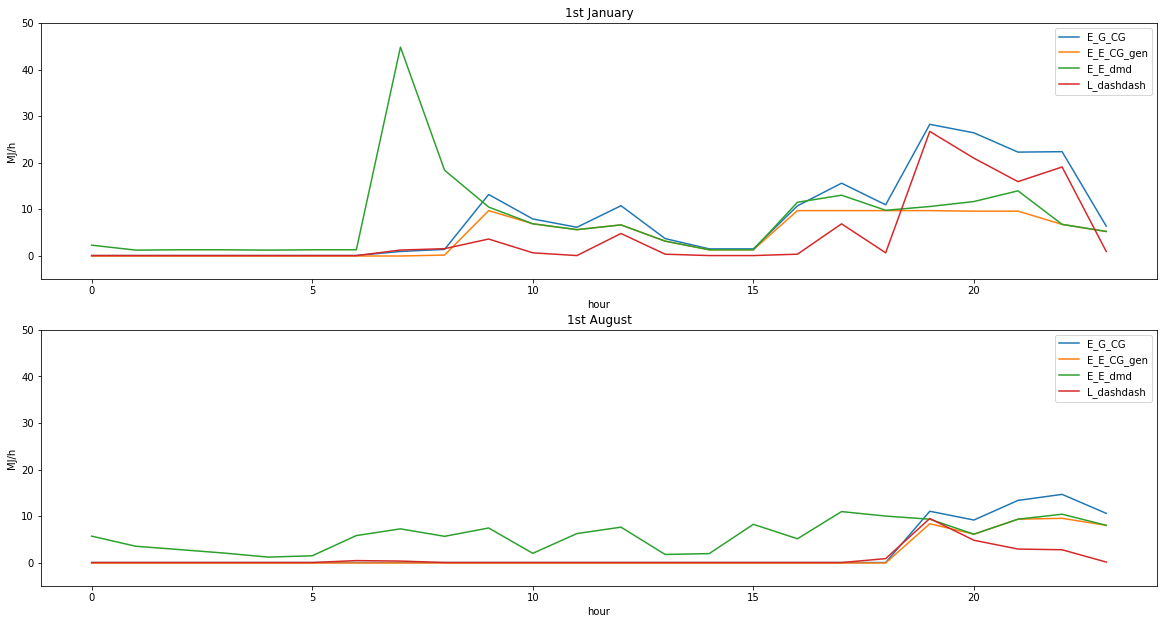

In [50]:
get_graphs(testcase1_E_G_CG_d_t, testcase1_E_E_CG_gen_d_t, testcase1_E_E_dmd_d_t, testcase1_L_dashdash_d_t)

### 計算条件2

In [40]:
param = {'region' : 6,  'A_A' : 120, 'A_MR' : 30, 'A_OR' : 50, 'mode_MR' : None, 'mode_OR' : None,
         'bath_function' : "ふろ給湯機(追焚あり)", 'CG' : {'CG_category' : 'PEFC3'}}


testcase2_E_G_CG_d_t, testcase2_E_E_CG_gen_d_t, testcase2_E_E_dmd_d_t, testcase2_L_dashdash_d_t = get_results(param)

testcase2_E_G_CG = np.sum(testcase2_E_G_CG_d_t)
testcase2_E_E_CG_gen = np.sum(testcase2_E_E_CG_gen_d_t)

print('testcase2：CGSのtypeは{}、一次エネルギー消費量は{}MJ/a、発電量は{}kWh/a'.format(param['CG']['CG_category'], 
                                                                   round(testcase2_E_G_CG), 
                                                                   round(testcase2_E_E_CG_gen)))


testcase2：CGSのtypeはPEFC3、一次エネルギー消費量は41976MJ/a、発電量は2981kWh/a


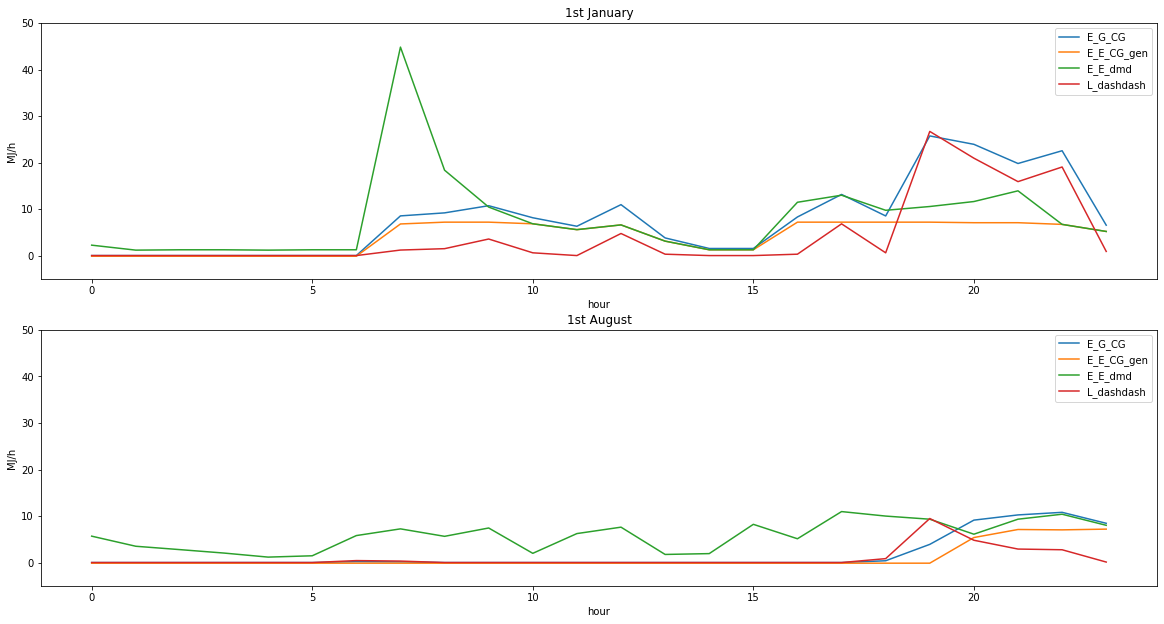

In [41]:
get_graphs(testcase2_E_G_CG_d_t, testcase2_E_E_CG_gen_d_t, testcase2_E_E_dmd_d_t, testcase2_L_dashdash_d_t)

### 計算条件3

In [42]:
param = {'region' : 6,  'A_A' : 120, 'A_MR' : 30, 'A_OR' : 50, 'mode_MR' : None, 'mode_OR' : None,
         'bath_function' : "ふろ給湯機(追焚あり)", 'CG' : {'CG_category' : 'SOFC2'}}


testcase3_E_G_CG_d_t, testcase3_E_E_CG_gen_d_t, testcase3_E_E_dmd_d_t, testcase3_L_dashdash_d_t = get_results(param)

testcase3_E_G_CG = np.sum(testcase3_E_G_CG_d_t)
testcase3_E_E_CG_gen = np.sum(testcase3_E_E_CG_gen_d_t)

print('testcase3：CGSのtypeは{}、一次エネルギー消費量は{}MJ/a、発電量は{}kWh/a'.format(param['CG']['CG_category'], 
                                                                   round(testcase3_E_G_CG), 
                                                                   round(testcase3_E_E_CG_gen)))


testcase3：CGSのtypeはSOFC2、一次エネルギー消費量は47993MJ/a、発電量は3635kWh/a


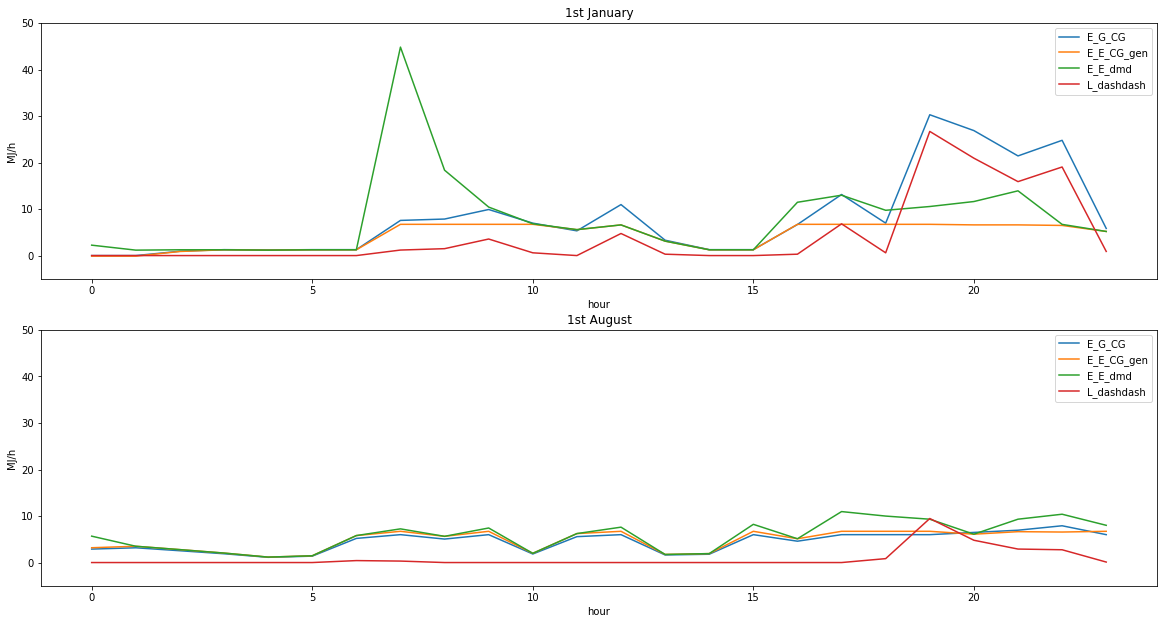

In [43]:
get_graphs(testcase3_E_G_CG_d_t, testcase3_E_E_CG_gen_d_t, testcase3_E_E_dmd_d_t, testcase3_L_dashdash_d_t)

### 計算条件4

In [44]:
param = {'region' : 6,  'A_A' : 120, 'A_MR' : 30, 'A_OR' : 50, 'mode_MR' : None, 'mode_OR' : None,
         'bath_function' : "ふろ給湯機(追焚あり)", 'CG' : {'CG_category' : 'GEC1'}}


testcase4_E_G_CG_d_t, testcase4_E_E_CG_gen_d_t, testcase4_E_E_dmd_d_t, testcase4_L_dashdash_d_t = get_results(param)

testcase4_E_G_CG = np.sum(testcase4_E_G_CG_d_t)
testcase4_E_E_CG_gen = np.sum(testcase4_E_E_CG_gen_d_t)

print('testcase4：CGSのtypeは{}、一次エネルギー消費量は{}MJ/a、発電量は{}kWh/a'.format(param['CG']['CG_category'], 
                                                                   round(testcase4_E_G_CG), 
                                                                   round(testcase4_E_E_CG_gen)))


testcase4：CGSのtypeはGEC1、一次エネルギー消費量は36095MJ/a、発電量は1250kWh/a


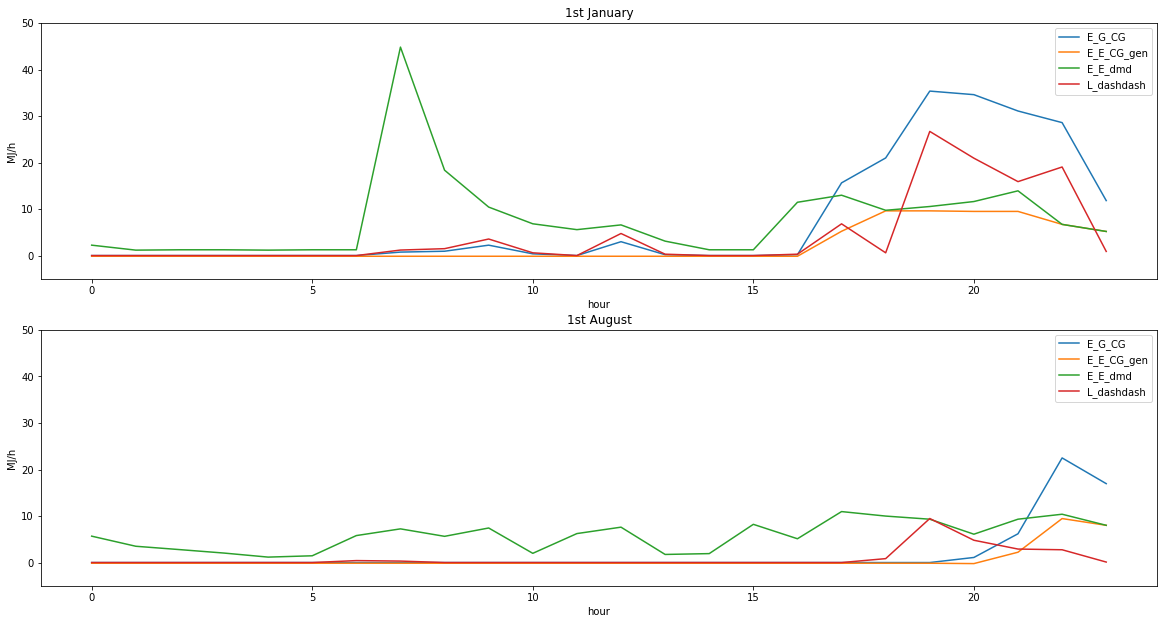

In [45]:
get_graphs(testcase4_E_G_CG_d_t, testcase4_E_E_CG_gen_d_t, testcase4_E_E_dmd_d_t, testcase4_L_dashdash_d_t)

### 計算条件5

In [46]:
param = {'region' : 6,  'A_A' : 120, 'A_MR' : 30, 'A_OR' : 50, 'mode_MR' : None, 'mode_OR' : None,
         'bath_function' : "ふろ給湯機(追焚あり)", 'CG' : {'package_id': 1}}

CG = {'package_id': 1}
sbst = get_cgs_param(**CG)

for key in sbst:
    # print(key)
    param['CG'][key] = sbst[key]


testcase5_E_G_CG_d_t, testcase5_E_E_CG_gen_d_t, testcase5_E_E_dmd_d_t, testcase5_L_dashdash_d_t = get_results(param)

testcase5_E_G_CG = np.sum(testcase5_E_G_CG_d_t)
testcase5_E_E_CG_gen = np.sum(testcase5_E_E_CG_gen_d_t)

print('testcase5：CGSのtypeは{}、一次エネルギー消費量は{}MJ/a、発電量は{}kWh/a'.format(param['CG']['CGS_type'], 
                                                                   round(testcase5_E_G_CG), 
                                                                   round(testcase5_E_E_CG_gen)))



testcase5：CGSのtypeはSOFC、一次エネルギー消費量は47993MJ/a、発電量は3635kWh/a


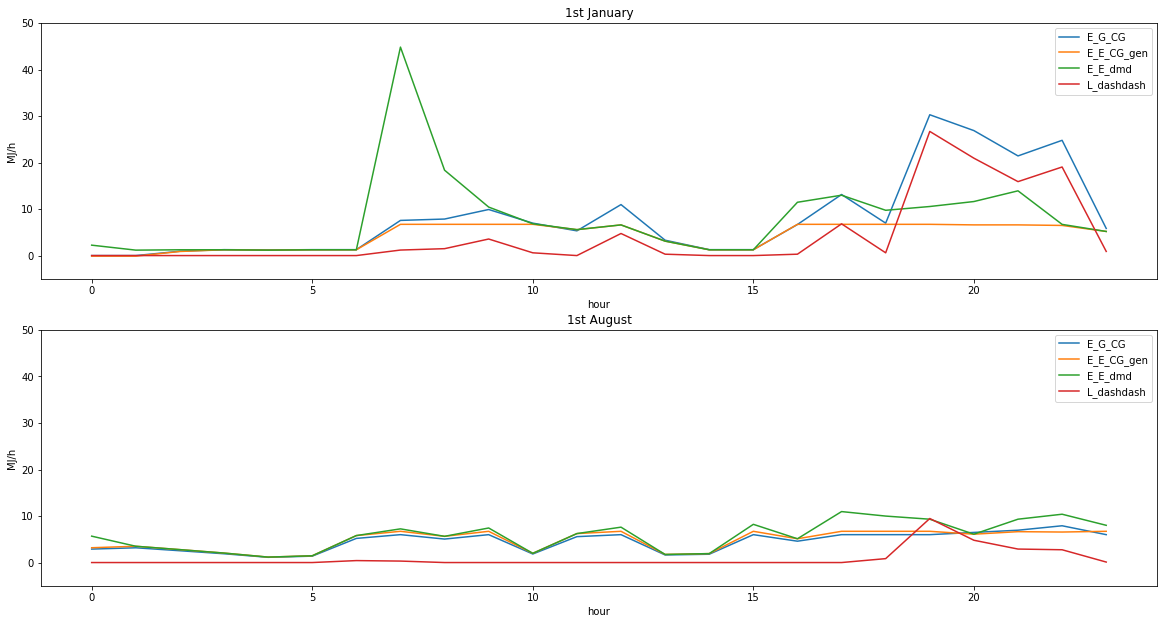

In [47]:
get_graphs(testcase5_E_G_CG_d_t, testcase5_E_E_CG_gen_d_t, testcase5_E_E_dmd_d_t, testcase5_L_dashdash_d_t)

### 比較

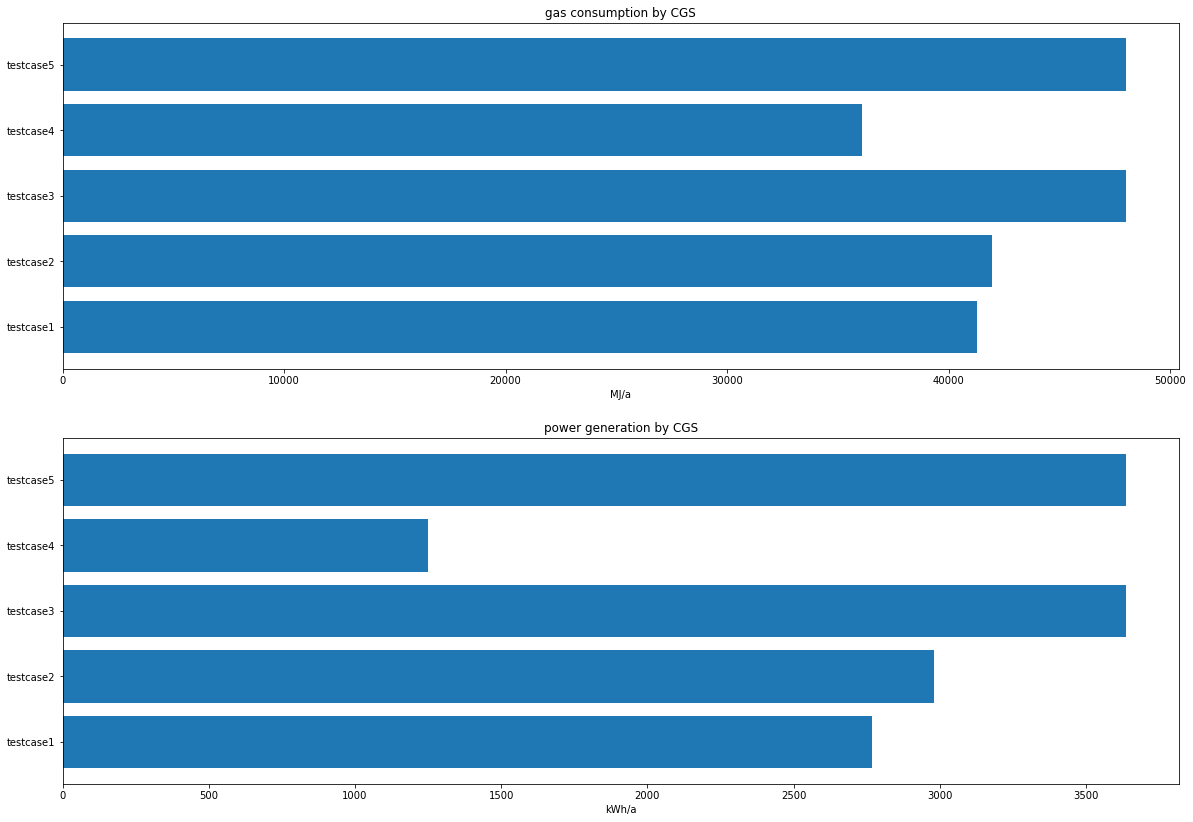

In [48]:
dat_E_G_CG = {"testcase1":testcase1_E_G_CG,"testcase2" : testcase2_E_G_CG, "testcase3" : testcase3_E_G_CG, 
              "testcase4" : testcase4_E_G_CG, "testcase5" : testcase5_E_G_CG}

dat_E_E_CG_gen = {"testcase1":testcase1_E_E_CG_gen,"testcase2" : testcase2_E_E_CG_gen, "testcase3" : testcase3_E_E_CG_gen, 
                  "testcase4" : testcase4_E_E_CG_gen, "testcase5" : testcase5_E_E_CG_gen}
xx = list(dat_E_G_CG.keys())
yy_E_G_CG = list(dat_E_G_CG.values())
yy_E_E_CG_gen = list(dat_E_E_CG_gen.values())

fig = plt.figure(figsize=(20,14))
axt1 = fig.add_subplot(211)
axt1.barh(xx,yy_E_G_CG)
axt1.set_xlabel("MJ/a")
axt1.set_title("gas consumption by CGS")

axt2 = fig.add_subplot(212)
axt2.barh(xx,yy_E_E_CG_gen)
axt2.set_xlabel("kWh/a")
axt2.set_title("power generation by CGS")

plt.show()
